# UQ Analysis of RFQ Dataset (09-24-2020)

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3);
                                         font-size: 15px">
        <strong>Requirements:</strong>
        <ul>
            <li>pyOPALTools (https://gitlab.psi.ch/OPAL/pyOPALTools/-/tags/pyOPALTools-25-09-2020)</li>
            <li>UQTk (https://github.com/sandialabs/UQTk)</li>
        </ul>
    </div>
</html>
    

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Define Global Variables</strong>
    </div>
</html>

In [1]:
# renamed file: 'Dataset_RFQ-model_01_(09-24-2020).txt' --> 'dataset_0.json'
fname = 'dataset_0.json'

# polynomial chaos expansion order
order = 2
iteration = 1

In [2]:
from db import mldb
import numpy as np


#from mllib.model import *
#from mllib.data import OpalDataSource
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

database = mldb.mldb()

database.buildFromSampler(fname, '.', '')

OPAL ML Database Generator 
Write ML-Database sampler.pk


In [3]:
database.printOverview ()

xDim        = 2 -> ['DVAR1', 'DVAR2']
yDim        = 4 -> ['OBJ1', 'OBJ2', 'OBJ3', 'OBJ4']
generations = 1
Data points  = 1001
Show first dataset from generation 0: y = f(x)
[38.27     0.11036  0.08641  0.09705] = f([3.02218 5.87732])


<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Save Input and Output</strong>
    </div>
</html>

In [4]:
"""Note: The ordering of the intput and output data are ordered according to 'xnames' and 'ynames' which does not
necessarily mean an increasing ordering, i.e., DVAR1, DVAR2, ... or OBJ1, OBJ", ..., respectively.
"""
import numpy as np
xnames = database.getXNames()
ynames = database.getYNames()
xdim = database.getXDim()
ydim = database.getYDim()
nsamples = database.getSampleSize()

In [5]:
xvals = np.zeros((nsamples, xdim))
yvals = np.zeros((nsamples, ydim))
for i in range(nsamples):
    xvals[i] = database.getDVarVec(0, i)
    yvals[i] = database.getObjVec(0, i)

# save data, might be used for Neural Network training
np.save('rfq_input.npy', xvals)
np.save('rfq_output.npy',yvals)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Obtain Domain of Interest from Data</strong>
    </div>
</html>

In [6]:
import numpy as np
pdom = np.empty((2, len(xnames)))

bounds = database.getBounds()

for i in range(len(xnames)):
    pdom[0, i] = bounds[xnames[i]][0]
    pdom[1, i] = bounds[xnames[i]][1]

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Split into Training and Validation Data</strong>
    </div>
</html>

In [7]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(xvals, yvals, test_size=0.3, random_state=42)

print('Training size:   ', np.shape(xtrain)[0])
print('Validation size: ', np.shape(ytest)[0])
#ytrain = keras.utils.to_categorical(ytrain)

#ytest = keras.utils.to_categorical(ytest)

Training size:    700
Validation size:  301



<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Analysis Functions</strong>
    </div>
</html>

###  Error Measures and Sensitivity Computation

In [8]:
# error measures
def eval_l2_error(ytrue, ypred):
    return np.linalg.norm(ytrue - ypred, ord=2) / np.linalg.norm(ytrue, ord=2)

def eval_l1_error(ytrue, ypred):
    return np.linalg.norm(ytrue - ypred, ord=1) / np.linalg.norm(ytrue, ord=1)

def compute_sensitivity(xtrain, ytrain, order, pdom):
    import numpy as np
    allsens_m = np.zeros((len(ytrain[0]), len(xtrain[0])))
    allsens_t = np.zeros((len(ytrain[0]), len(xtrain[0])))
    
    # load the UQ interface
    from surrogate.uqtk_model import UQTk as UQ
    #from surrogate.chaospy_model import UQChaospy as UQ
    
    
    for i in range(len(ytrain[0])):
        # delete
        uq = None

        # setup the UQ analysis ( lsq : least squares method )
        uq = UQ(pdom=pdom, order=order, method='lsq')
    
        # train the surrogate model
        uq.fit(xtrain, ytrain[:, i])
        
        allsens_m[i, :] = uq.main_sensitivity()
        allsens_t[i, :] = uq.total_sensitivity()
    
    return allsens_m, allsens_t

###  Sensitivity Plotting Tools

In [9]:
def plot_sens(sensdata,pars,cases,vis="bar",
              par_labels=[], case_labels=[],colors=[],ncol=4,grid_show=True,xlbl='',
              legend_show=2,xdatatick=None,figname='sens.eps',showplot=False, **kwargs):

    """Plots sensitivity for multiple observables"""
    import matplotlib.pyplot as plt
    ncases=sensdata.shape[0]
    npar=sensdata.shape[1]
    
    sens_type = kwargs.pop('sens_type', '')

    wd=0.6
    ylbl= sens_type + ' Sensitivity'


    assert set(pars) <= set(range(npar))
    assert set(cases) <= set(range(ncases))

    npar_=len(pars)
    ncases_=len(cases)

    case_labels_=[]
    for i in range(ncases_):
        case_labels_.append(case_labels[cases[i]])

    if xdatatick==None:
        xflag=False
        xdatatick=np.array(list(range(1,ncases_+1)))
        sc=1.
    else:
        xflag=True
        sc=(xdatatick[-1]-xdatatick[0])/ncases_

    if (vis=="graph"):
        for i in range(npar_):
            plt.plot(xdatatick_,sensdata[cases,i], '-o',color=colors[pars[i]], label=par_labels[pars[i]])
    elif (vis=="bar"):
        curr=np.zeros((ncases_))
        #print pars,colors
        for i in range(npar_):
            plt.bar(xdatatick,sensdata[cases,i], width=wd*sc,color=colors[pars[i]], bottom=curr,
                    label=par_labels[pars[i]], capsize=5, ecolor='black')
            curr=sensdata[cases,i]+curr
        if not xflag:
            plt.xticks(np.array(list(range(1,ncases_+1))),case_labels_)
        plt.xlim(xdatatick[0]-wd*sc/2.,xdatatick[-1]+wd*sc/2.)

    plt.ylabel(ylbl)
    plt.xlabel(xlbl)

    maxsens=max(max(curr),1.0)
    plt.ylim([0,maxsens])
    if legend_show==1:
        plt.legend()
    elif (legend_show==2):
        plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.1), ncol=ncol)
    elif legend_show == 3:
        bb_shift = kwargs.pop('bb_shift', 0.0)
        plt.legend(loc = 'upper left', bbox_to_anchor=(-0.75+bb_shift, 1.25), ncol=ncol)
        #legend(bbox_to_anchor=(0.0, -0.05),fancybox=True, shadow=True,ncol=5,labelspacing=-0.1)

    #if not xflag:
    #    zed = [tick.label.set_fontsize(xticklabel_size) for tick in plt.gca().xaxis.get_major_ticks()]

    plt.grid(grid_show, linestyle='dashed', axis='y')
    #plt.tight_layout()
    return plt

def plot_sensitivity(sensdata, dnames, outnames, **kwargs):
    import matplotlib.pyplot as plt
    ## Get basic dimensions
    nout=len(outnames)
    ndim=np.shape(sensdata)[1]
    print("Dimensionality : ", ndim)
    print("Num of outputs : ", nout)

    pars=list(range(ndim))
    cases=list(range(nout))

    # 11. March 2019
    # https://stackoverflow.com/questions/43938425/matplotlib-change-colormap-tab20-to-have-three-colors
    colors = plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )

    return plot_sens(sensdata, pars, cases, vis='bar', colors=colors,
                     par_labels=dnames,case_labels=outnames,ncol=int(0.5*ndim),
                     grid_show=True, xlbl='', **kwargs)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Train UQ Model and Check the Error</strong>
    </div>
</html>

In [10]:
#!/usr/bin/env python
"""Demonstrate Keras model weight shuffling as fast alternative to re-creating a model."""

from __future__ import print_function

import numpy as np
from keras.layers import Dense
from keras.models import Sequential


def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)


# def main():
#     """Train a simple single layer to learn the sum of three inputs.
#     Shuffle weights in a mock "cross-validation" loop instead of re-creating the model to save time.
#     """
#     np.random.seed(42)
#     model = Sequential((
#         Dense(input_dim=3, output_dim=1, activation='linear'),
#     ))
#     model.compile(loss='msle', optimizer='rmsprop')

#     X = np.random.random(size=(1000, 3))
#     y = np.sum(X, axis=1)

#     initial_weights = model.get_weights()
#     print('Initial weights:\n', initial_weights)

#     for rnd in xrange(3):
#         shuffle_weights(model, initial_weights)
#         print('\nRound {} starting weights:\n'.format(rnd), model.get_weights())
#         hist = model.fit(X, y, nb_epoch=50, verbose=0)
#         print('Learned weights:\n', model.get_weights(), '\nloss:', hist.history['loss'][-1])


# if __name__ == '__main__':
#     main()

In [11]:


class Antirectifier(layers.Layer):
    def __init__(self, initializer="he_normal", **kwargs):
        super(Antirectifier, self).__init__(**kwargs)
        self.initializer = keras.initializers.get(initializer)

    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(output_dim * 2, output_dim),
            initializer=self.initializer,
            name="kernel",
            trainable=True,
        )

    def call(self, inputs):
        inputs -= tf.reduce_mean(inputs, axis=-1, keepdims=True)
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        concatenated = tf.concat([pos, neg], axis=-1)
        mixed = tf.matmul(concatenated, self.kernel)
        return mixed

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(Antirectifier, self).get_config()
        config = {"initializer": keras.initializers.serialize(self.initializer)}
        return dict(list(base_config.items()) + list(config.items()))


In [12]:
# load the UQ interface
#from surrogate.uqtk_model import UQTk as UQ
#from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

#xtrain = xtrain.reshape(-1,14)
#ytrain=ytrain.reshape(-1,6)
models=[]

# Training parameters
batch_size = 500

epochs = 10000

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else: 
        return v / norm









obj=0
models=[]
norms=[]

print(len(ytrain[:,obj]))
print(len(ytrain[obj,:]))
while obj<ydim:
    
    
    
    model = Sequential()
    model.add(Dense(14, input_dim=xdim, activation='sigmoid'))
#model.add(Dropout(0.5))
#add in sigmoids/tanh
#check bias terms
#go big immediately
#plot loss

#model.add(Dense(24, activation='relu'))
#model.add(Dropout(0.2))

#model.add(Dense(48, activation='relu'))
#model.add(Dropout(0.5))


#model.add(Dense(100, activation='tanh'))
#model.add(Dropout(0.8))


# model.add(Dense(80, activation='sigmoid'))

# model.add(Dense(50, activation='tanh'))

# model.add(Dense(50, activation='tanh'))

# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='tanh'))
# model.add(Dense(20, activation='sigmoid'))




    model.add(Dense(10, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(14, activation='tanh'))





# model.add(Dense(100, activation='tanh'))

# model.add(Dense(100, activation='tanh'))

# model.add(Dense(48, activation='sigmoid'))
# #model.add(Dropout(0.8))

# model.add(Dense(24, activation='sigmoid'))
# #model.add(Dropout(0.2))

# model.add(Dense(20, activation='sigmoid'))
#model.add(Dropout(0.5))
# never reduces smaller than input

    model.add(Dense(1, activation='sigmoid'))

#model.add(Dense(6))
    model.summary()
    
    
    
    
    
    # Compile the model
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        #use loss squared function
        #optimizer=keras.optimizers.Adam(learning_rate=.0136),
        optimizer=keras.optimizers.Adam(learning_rate=.001),
        #switch to adam
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

    
    normfactor=np.max(ytrain[:,obj])*1.1
    print(normfactor)
    #normfactor=normalize(ytrain[:,obj])
    #trainer=normalize(ytrain[:,obj])
    norms.append(normfactor)
    model.fit(xtrain, ytrain[:,obj]/normfactor, batch_size=batch_size, epochs=epochs, validation_split=0.0)
    # Test the model
    #model.evaluate(xtest, ytest[:,obj])
    models.append(model)
    obj=obj+1
    #shuffle_weights(model, weights=None)
    
obj=1


#print(xtrain[1,:])
#print(ytrain[9,:])





    



    

700
4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                42        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 14)                294       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 15        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
________________________________________________

2/2 [==============================] - 0s 6ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.0000e+00
Epoch 58/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.0000e+00
Epoch 59/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.0067 - sparse_categorical_accuracy: 0.0000e+00
Epoch 60/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.0000e+00
Epoch 61/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.0054 - sparse_categorical_accuracy: 0.0000e+00
Epoch 62/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.0048 - sparse_categorical_accuracy: 0.0000e+00
Epoch 63/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0043 - sparse_categorical_accuracy: 0.0000e+00
Epoch 64/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.0038 - sparse_categorical_accuracy: 0.0000e+00
Epoch 65/10000
2/2 [===========

2/2 [==============================] - 0s 7ms/step - loss: 8.5909e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 123/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5300e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 124/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.4668e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 125/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.4199e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 126/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.3651e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 127/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.3065e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 128/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.2575e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 129/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2053e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 7ms/step - loss: 6.7518e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 186/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7509e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 187/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7406e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 188/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7201e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 189/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7101e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 190/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7050e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 191/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.6957e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 192/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6830e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 6ms/step - loss: 6.3140e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 248/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3034e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 249/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3190e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 250/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.3003e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 251/10000
2/2 [==============================] - 0s 15ms/step - loss: 6.2969e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 252/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3146e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 253/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2793e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 254/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.2861e-04 - sparse_categorical_accuracy: 0.

2/2 [==============================] - 0s 4ms/step - loss: 5.9929e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 311/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.9834e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 312/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9743e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 313/10000
2/2 [==============================] - 0s 11ms/step - loss: 5.9702e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 314/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.9601e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 315/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9567e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 316/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9498e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 317/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9451e-04 - sparse_categorical_accuracy: 0.

2/2 [==============================] - 0s 14ms/step - loss: 5.6024e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 375/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5955e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 376/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5898e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 377/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5848e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 378/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5758e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 379/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5709e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 380/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5630e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 381/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5586e-04 - sparse_categorical_accuracy: 0.

2/2 [==============================] - 0s 7ms/step - loss: 5.2490e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 437/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2415e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 438/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.2363e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 439/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2305e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 440/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2271e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 441/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2194e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 442/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.2145e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 443/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.2093e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 4.9038e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 499/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.8998e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 500/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8948e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 501/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8950e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 502/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.8819e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 503/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8728e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 504/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.8626e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 505/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8546e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 2ms/step - loss: 4.1496e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 563/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1358e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 564/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1222e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 565/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1058e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 566/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0909e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 567/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0714e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 568/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0560e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 569/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0510e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 2.9098e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 627/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.8844e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 628/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.8600e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 629/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8428e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 630/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.8124e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 631/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7911e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 632/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7745e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 633/10000
2/2 [==============================] - ETA: 0s - loss: 2.6493e-04 - sparse_categorical_accuracy: 0.0000e

2/2 [==============================] - 0s 3ms/step - loss: 1.7668e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 688/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7496e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 689/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7399e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 690/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.7289e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 691/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7115e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 692/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7072e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 693/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6870e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 694/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6829e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 4ms/step - loss: 1.1899e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 749/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.1893e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 750/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1745e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 751/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1682e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 752/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1691e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 753/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1613e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 754/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1503e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 755/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1589e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 9ms/step - loss: 8.6454e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 813/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2898e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 814/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2267e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 815/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1799e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 816/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1421e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 817/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.1846e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 818/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1922e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 819/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.1015e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 5ms/step - loss: 6.0813e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 876/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.0389e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 877/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0598e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 878/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9887e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 879/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9605e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 880/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.9772e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 881/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9026e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 882/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9459e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 4.7971e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 939/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7940e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 940/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7964e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 941/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.8108e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 942/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7357e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 943/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.7993e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 944/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.7118e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 945/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7835e-05 - sparse_categorical_accuracy: 0.0

Epoch 1002/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2086e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1003/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.1187e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1004/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1109e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1005/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0820e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1006/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1113e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1007/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1328e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1008/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2135e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1009/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1672e-05 - sparse_c

Epoch 1065/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.7887e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1066/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7844e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1067/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.7415e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1068/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7247e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1069/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7051e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1070/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7617e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1071/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9334e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1072/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0493e-05 - sparse_c

Epoch 1128/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5078e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1129/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.4946e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1130/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5200e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1131/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5468e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1132/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5360e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1133/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5283e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1134/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5953e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1135/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5057e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 3.3274e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1191/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3355e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1192/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.3278e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1193/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.3314e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1194/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3057e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1195/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3768e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1196/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3192e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1197/10000
2/2 [==============================] - ETA: 0s - loss: 3.1575e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 8ms/step - loss: 3.2276e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1254/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2787e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1255/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.2765e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1256/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2101e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1257/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1904e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1258/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3526e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1259/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.1955e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1260/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.2146e-05 - sparse_categorical_accura

Epoch 1315/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1628e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1316/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1753e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1317/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.1682e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1318/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1904e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1319/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1874e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1320/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1278e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1321/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1642e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1322/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.1547e-05 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 3.1300e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1378/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0967e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1379/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.0968e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1380/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.1603e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1381/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1358e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1382/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.0628e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1383/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0364e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1384/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.0793e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.2450e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1441/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1969e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1442/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1250e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1443/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0961e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1444/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.0166e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1445/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1240e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1446/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.0141e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1447/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.0192e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 3.1511e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1504/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.3324e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1505/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9736e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1506/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2188e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1507/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9698e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1508/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0523e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1509/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9237e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1510/10000
2/2 [==============================] - ETA: 0s - loss: 3.1306e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 3ms/step - loss: 3.3446e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1566/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.1321e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1567/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9568e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1568/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1728e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1569/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0796e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1570/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.2026e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1571/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8981e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1572/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9230e-05 - sparse_categorical_accura

Epoch 1628/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8186e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1629/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9122e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1630/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.8331e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1631/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.8278e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1632/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8339e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1633/10000
2/2 [==============================] - ETA: 0s - loss: 2.8618e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.9073e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1634/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9627e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1635/10000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 2.9354e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1691/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.7931e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1692/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7968e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1693/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7829e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1694/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.8208e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1695/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8216e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1696/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8977e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1697/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.9361e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 2.8037e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1753/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7465e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1754/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7429e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1755/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7440e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1756/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7340e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1757/10000
2/2 [==============================] - ETA: 0s - loss: 2.6799e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.7618e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1758/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.7962e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1759/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 2.7959e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1815/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7643e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1816/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.7555e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1817/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7148e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1818/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6780e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1819/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.6906e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1820/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.7534e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1821/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.7323e-05 - sparse_categorical_accura

Epoch 1877/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6738e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1878/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8275e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1879/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6749e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1880/10000
2/2 [==============================] - 0s 9ms/step - loss: 2.7820e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1881/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6880e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1882/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.7084e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1883/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.6906e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1884/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6657e-05 - sparse_c

Epoch 1940/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.0854e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1941/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1012e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1942/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0625e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1943/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0484e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1944/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1581e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1945/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7771e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1946/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6876e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1947/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6531e-05 - sparse_c

2/2 [==============================] - 0s 5ms/step - loss: 2.6537e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2004/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6296e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2005/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5911e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2006/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5645e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2007/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6387e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2008/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5337e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2009/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7382e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2010/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.7430e-05 - sparse_categorical_accura

Epoch 2065/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6891e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2066/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.4845e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2067/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4775e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2068/10000
2/2 [==============================] - ETA: 0s - loss: 2.6100e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 2.5335e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2069/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4849e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2070/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4785e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2071/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4760e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2072/10000
2/2 [=====

2/2 [==============================] - 0s 4ms/step - loss: 2.5496e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2127/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.6691e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2128/10000
2/2 [==============================] - ETA: 0s - loss: 2.5209e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.6344e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2129/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6446e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2130/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5625e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2131/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6141e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2132/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.5971e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2133/10000
2/2 [======================

2/2 [==============================] - 0s 2ms/step - loss: 2.4659e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2189/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3792e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2190/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3934e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2191/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4185e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2192/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4392e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2193/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5012e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2194/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4190e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2195/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4312e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.6551e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2252/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3255e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2253/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3925e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2254/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.3384e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2255/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3868e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2256/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.3343e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2257/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3094e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2258/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2999e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.3474e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2315/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3163e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2316/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.3761e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2317/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.5335e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2318/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4690e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2319/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.4222e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2320/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4874e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2321/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4210e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.4123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2376/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3143e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2377/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.1905e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2378/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.1912e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2379/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.2493e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2380/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3097e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2381/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3074e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2382/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3616e-05 - sparse_categorical_accura

Epoch 2438/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1882e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2439/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1318e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2440/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.1302e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2441/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.1746e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2442/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.2070e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2443/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4137e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2444/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.3550e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2445/10000
2/2 [==============================] - ETA: 0s - loss: 2.4105e-05 - sparse_categ

2/2 [==============================] - 0s 4ms/step - loss: 2.5056e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2501/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.5067e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2502/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.7511e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2503/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.2163e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2504/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2378e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2505/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2724e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2506/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2138e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2507/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1021e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 2.0224e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2564/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9909e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2565/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9638e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2566/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9815e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2567/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9774e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2568/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9745e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2569/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9883e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2570/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0066e-05 - sparse_categorical_accura

Epoch 2626/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9492e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2627/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9750e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2628/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9778e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2629/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9338e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2630/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9237e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2631/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9568e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2632/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9518e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2633/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9253e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.8574e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2690/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8598e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2691/10000
2/2 [==============================] - 0s 10ms/step - loss: 1.8622e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2692/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8552e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2693/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.8530e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2694/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8602e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2695/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8763e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2696/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9228e-05 - sparse_categorical_accur

2/2 [==============================] - 0s 6ms/step - loss: 1.8008e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2753/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9009e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2754/10000
2/2 [==============================] - ETA: 0s - loss: 1.7273e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 1.7892e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2755/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7652e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2756/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8432e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2757/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8571e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2758/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7963e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2759/10000
2/2 [======================

2/2 [==============================] - 0s 6ms/step - loss: 1.8676e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2815/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8370e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2816/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9941e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2817/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7912e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2818/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7963e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2819/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8017e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2820/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7223e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2821/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7591e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.6700e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2878/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6586e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2879/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6558e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2880/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6483e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2881/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6768e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2882/10000
2/2 [==============================] - ETA: 0s - loss: 1.7310e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.6717e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2883/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8405e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2884/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.7337e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2939/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6417e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2940/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5758e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2941/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5797e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2942/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5750e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2943/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.5791e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2944/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6008e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2945/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6005e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.5552e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3002/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5228e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3003/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5439e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3004/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4976e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3005/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5558e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3006/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6588e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3007/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.6156e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3008/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5192e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5803e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3065/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5411e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3066/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.6363e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3067/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4928e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3068/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4533e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3069/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.5089e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3070/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5070e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3071/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4207e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5464e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3127/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6621e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3128/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6829e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3129/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8820e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3130/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3285e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3131/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1593e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3132/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.4902e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3133/10000
2/2 [==============================] - ETA: 0s - loss: 4.1629e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 3ms/step - loss: 1.2768e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3190/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2776e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3191/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2868e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3192/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2942e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3193/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2964e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3194/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3781e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3195/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.2760e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3196/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2672e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.2209e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3253/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2129e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3254/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2068e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3255/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2393e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3256/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2860e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3257/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.2172e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3258/10000
2/2 [==============================] - 0s 10ms/step - loss: 1.1652e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3259/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1827e-05 - sparse_categorical_accur

2/2 [==============================] - 0s 3ms/step - loss: 1.2666e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3315/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.1398e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3316/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1472e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3317/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1457e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3318/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1292e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3319/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0880e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3320/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.1469e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3321/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0864e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 9.8839e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3378/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8582e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3379/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0068e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3380/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.0326e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3381/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0056e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3382/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0061e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3383/10000
2/2 [==============================] - ETA: 0s - loss: 1.0051e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 8ms/step - loss: 9.8022e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3384/10000
2/2 [======================

Epoch 3439/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5257e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3440/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4540e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3441/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4540e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3442/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1858e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3443/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0936e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3444/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.8808e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3445/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1898e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3446/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0844e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 8.7316e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3503/10000
2/2 [==============================] - 0s 8ms/step - loss: 8.8980e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3504/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6853e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3505/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7593e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3506/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.5904e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3507/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.5529e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3508/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.3868e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3509/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2182e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.8237e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3566/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.7264e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3567/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8110e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3568/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.8076e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3569/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8421e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3570/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.7209e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3571/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.7784e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3572/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.6837e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.6610e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3629/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0748e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3630/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.0585e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3631/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.4070e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3632/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.7238e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3633/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1789e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3634/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9671e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3635/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0561e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.9776e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3692/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8636e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3693/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.2565e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3694/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.9701e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3695/10000
2/2 [==============================] - 0s 10ms/step - loss: 7.2015e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3696/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1023e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3697/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.2173e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3698/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7977e-06 - sparse_categorical_accur

2/2 [==============================] - 0s 4ms/step - loss: 7.9451e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3755/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5281e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3756/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4861e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3757/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8426e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3758/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7434e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3759/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8512e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3760/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.6089e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3761/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6832e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.5079e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3818/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3358e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3819/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.3814e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3820/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2411e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3821/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.4518e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3822/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.1276e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3823/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.6130e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3824/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7898e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 5.9776e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3881/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.0599e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3882/10000
2/2 [==============================] - ETA: 0s - loss: 6.1170e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 6.0481e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3883/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2862e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3884/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.2229e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3885/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.0670e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3886/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8887e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3887/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 5.8191e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3943/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0716e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3944/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8617e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3945/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.0228e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3946/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0840e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3947/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6113e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3948/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1918e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3949/10000
2/2 [==============================] - 0s 9ms/step - loss: 6.0162e-06 - sparse_categorical_accura

Epoch 4005/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3316e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4006/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9267e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4007/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7980e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4008/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.9626e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4009/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.1181e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4010/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5752e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4011/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2191e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4012/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5027e-06 - sparse_c

2/2 [==============================] - 0s 5ms/step - loss: 5.4832e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4068/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5124e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4069/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4791e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4070/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4437e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4071/10000
2/2 [==============================] - ETA: 0s - loss: 5.0752e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 5.4674e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4072/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4291e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4073/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5974e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4074/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 5.4396e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4130/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4184e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4131/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.9551e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4132/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.5048e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4133/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.6921e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4134/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7702e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4135/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6856e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4136/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0274e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.6501e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4192/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6512e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4193/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4117e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4194/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3428e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4195/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2016e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4196/10000
2/2 [==============================] - ETA: 0s - loss: 5.4346e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 5.7948e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4197/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7607e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4198/10000
2/2 [======================

2/2 [==============================] - 0s 6ms/step - loss: 6.4770e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4251/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5756e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4252/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.1745e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4253/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8720e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4254/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1421e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4255/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.5040e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4256/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4112e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4257/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0438e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.7986e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4314/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9069e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4315/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8045e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4316/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.7444e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4317/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8315e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4318/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9788e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4319/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4017e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4320/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.9357e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 7.3611e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4377/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.0114e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4378/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9115e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4379/10000
2/2 [==============================] - ETA: 0s - loss: 5.0408e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 5.2533e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4380/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0610e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4381/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1549e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4382/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.8804e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4383/10000
2/2 [======================

Epoch 4438/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1703e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4439/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3408e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4440/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9226e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4441/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.6116e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4442/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.6666e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4443/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8542e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4444/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1970e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4445/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7805e-06 - sparse_c

Epoch 4501/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5360e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4502/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6969e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4503/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.5190e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4504/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7412e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4505/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.3962e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4506/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4101e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4507/10000
2/2 [==============================] - ETA: 0s - loss: 4.9539e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 5ms/step - loss: 4.7203e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4508/10000
2/2 [=====

Epoch 4564/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4981e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4565/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8596e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4566/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6367e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4567/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8851e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4568/10000
2/2 [==============================] - ETA: 0s - loss: 4.1312e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.7375e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4569/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6856e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4570/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5167e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4571/10000
2/2 [=====

2/2 [==============================] - 0s 4ms/step - loss: 4.5338e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4627/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.4615e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4628/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.1250e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4629/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.4409e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4630/10000
2/2 [==============================] - 0s 11ms/step - loss: 5.4737e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4631/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5441e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4632/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4559e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4633/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2650e-06 - sparse_categorical_accur

2/2 [==============================] - 0s 4ms/step - loss: 4.9016e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4690/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6289e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4691/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6416e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4692/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3705e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4693/10000
2/2 [==============================] - ETA: 0s - loss: 4.2227e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.4354e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4694/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4936e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4695/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0715e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4696/10000
2/2 [======================

2/2 [==============================] - 0s 5ms/step - loss: 3.9856e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4753/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.1183e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4754/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1010e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4755/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9505e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4756/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0252e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4757/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4695e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4758/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7463e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4759/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4807e-06 - sparse_categorical_accura

2/2 [==============================] - ETA: 0s - loss: 3.8361e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.2375e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4815/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8391e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4816/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.7478e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4817/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0164e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4818/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.1246e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4819/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0571e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4820/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3804e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4821/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 4.4534e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4877/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3305e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4878/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0312e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4879/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0641e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4880/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6082e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4881/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.8885e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4882/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8037e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4883/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9601e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.7214e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4940/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1866e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4941/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4528e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4942/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.2629e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4943/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.9761e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4944/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0786e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4945/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1186e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4946/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2825e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.5474e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5003/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9037e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5004/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1458e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5005/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7572e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5006/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.8613e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5007/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4694e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5008/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2918e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5009/10000
2/2 [==============================] - 0s 9ms/step - loss: 3.6274e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.2401e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5065/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7347e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5066/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3134e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5067/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7136e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5068/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.6261e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5069/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.7428e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5070/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5517e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5071/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.5182e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.7126e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5127/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.6374e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5128/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.7744e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5129/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1921e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5130/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0103e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5131/10000
2/2 [==============================] - ETA: 0s - loss: 4.7933e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 5.0701e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5132/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6215e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5133/10000
2/2 [======================

Epoch 5189/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9675e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5190/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.7960e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5191/10000
2/2 [==============================] - ETA: 0s - loss: 4.0629e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 5ms/step - loss: 4.0453e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5192/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4734e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5193/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4483e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5194/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.4142e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5195/10000
2/2 [==============================] - ETA: 0s - loss: 3.2336e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 3.4535e-06

2/2 [==============================] - 0s 10ms/step - loss: 3.6385e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5251/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5912e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5252/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.3472e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5253/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3042e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5254/10000
2/2 [==============================] - 0s 9ms/step - loss: 3.7063e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5255/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4781e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5256/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3139e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5257/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.5326e-06 - sparse_categorical_accur

2/2 [==============================] - 0s 5ms/step - loss: 3.9410e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5314/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.2751e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5315/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2077e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5316/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.1689e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5317/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.3117e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5318/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1113e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5319/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1288e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5320/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5471e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 3.1029e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5377/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.1838e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5378/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2818e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5379/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0622e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5380/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.0686e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5381/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0479e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5382/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.9957e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5383/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0928e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.9306e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5440/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3163e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5441/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8741e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5442/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8252e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5443/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3926e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5444/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3494e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5445/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2242e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5446/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1156e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 3.8729e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5502/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.4346e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5503/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.4568e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5504/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3099e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5505/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.6173e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5506/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3969e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5507/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9229e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5508/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.0917e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 3.5271e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5565/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9697e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5566/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9386e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5567/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3640e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5568/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.9262e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5569/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3879e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5570/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.9019e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5571/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9385e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.1045e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5628/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1310e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5629/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.3042e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5630/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5555e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5631/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9548e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5632/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.8802e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5633/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.8633e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5634/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.8615e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.9879e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5691/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0720e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5692/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3522e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5693/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6173e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5694/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0753e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5695/10000
2/2 [==============================] - ETA: 0s - loss: 2.5440e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 2.7087e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5696/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3268e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5697/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 3.5730e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5753/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1556e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5754/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1448e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5755/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2186e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5756/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9742e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5757/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.3710e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5758/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6380e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5759/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.8793e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.8149e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5816/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.0415e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5817/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.9654e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5818/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4216e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5819/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9972e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5820/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8299e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5821/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2060e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5822/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.9458e-06 - sparse_categorical_accura

Epoch 5878/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8258e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5879/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.7769e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5880/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8719e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5881/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7769e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5882/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0297e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5883/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3723e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5884/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2956e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5885/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8741e-06 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 2.7555e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5942/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3895e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5943/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8806e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5944/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.5758e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5945/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.6805e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5946/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1571e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5947/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7244e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5948/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.6827e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.6553e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6005/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5528e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6006/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7946e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6007/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9427e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6008/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4890e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6009/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.5787e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6010/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5053e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6011/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8386e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 2.6174e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6068/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.8931e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6069/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.7222e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6070/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7831e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6071/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1709e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6072/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.1076e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6073/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5058e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6074/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3823e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 2.5615e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6130/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5962e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6131/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8987e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6132/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6426e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6133/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5424e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6134/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5782e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6135/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4422e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6136/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3671e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 2.4192e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6192/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5547e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6193/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.5571e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6194/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.6725e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6195/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.5955e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6196/10000
2/2 [==============================] - ETA: 0s - loss: 2.3903e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 2.3467e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6197/10000
2/2 [==============================] - 0s 11ms/step - loss: 2.3707e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6198/10000
2/2 [=====================

2/2 [==============================] - 0s 3ms/step - loss: 2.9176e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6254/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0885e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6255/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6566e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6256/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.3633e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6257/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4908e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6258/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4676e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6259/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6362e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6260/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.3000e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.1990e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6316/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.6490e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6317/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7604e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6318/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.4944e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6319/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3939e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6320/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4085e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6321/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2990e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6322/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.7239e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 2.3840e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6379/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.0902e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6380/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.8328e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6381/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4403e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6382/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7902e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6383/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2677e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6384/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5116e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6385/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2192e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.1871e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6440/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1783e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6441/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1824e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6442/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.7233e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6443/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3035e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6444/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2436e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6445/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.7132e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6446/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3535e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 2.8998e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6500/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3552e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6501/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3190e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6502/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.6919e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6503/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1563e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6504/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4399e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6505/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.6772e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6506/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1414e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.4143e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6562/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1141e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6563/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3268e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6564/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0891e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6565/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1454e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6566/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.1431e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6567/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1274e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6568/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.8753e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.0719e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6624/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.0968e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6625/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1820e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6626/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0990e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6627/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0993e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6628/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.5684e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6629/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.1020e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6630/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.1599e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.0241e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6687/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1437e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6688/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2864e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6689/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.8894e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6690/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2830e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6691/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3645e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6692/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.8595e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6693/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.4330e-06 - sparse_categorical_accura

2/2 [==============================] - ETA: 0s - loss: 2.1534e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 5ms/step - loss: 2.1578e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6749/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1702e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6750/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1677e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6751/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0086e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6752/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0821e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6753/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.0414e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6754/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9677e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6755/10000
2/2 [======================

2/2 [==============================] - 0s 5ms/step - loss: 2.4077e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6811/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.0790e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6812/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.6104e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6813/10000
2/2 [==============================] - 0s 9ms/step - loss: 2.2574e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6814/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5293e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6815/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7364e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6816/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5693e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6817/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8379e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 2.2731e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6874/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5286e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6875/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0800e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6876/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.4601e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6877/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9318e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6878/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9368e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6879/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1467e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6880/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.6152e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.0565e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6937/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1259e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6938/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3816e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6939/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9975e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6940/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.0225e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6941/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3493e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6942/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9743e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6943/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.0720e-06 - sparse_categorical_accura

Epoch 6999/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.0371e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7000/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9008e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7001/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.4417e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7002/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.4120e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7003/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5762e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7004/10000
2/2 [==============================] - 0s 9ms/step - loss: 3.0176e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7005/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3726e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7006/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.7000e-06 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 2.5904e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7061/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.1354e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7062/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3756e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7063/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3887e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7064/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0507e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7065/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4695e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7066/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3610e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7067/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0108e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.5198e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7123/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7210e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7124/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.7175e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7125/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4277e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7126/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.8540e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7127/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4598e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7128/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.8344e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7129/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8315e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.0737e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7185/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.4456e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7186/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.1942e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7187/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9584e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7188/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9079e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7189/10000
2/2 [==============================] - ETA: 0s - loss: 2.0985e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 2.0510e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7190/10000
2/2 [==============================] - ETA: 0s - loss: 1.8772e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 1.8145e-06 - sparse_categor

2/2 [==============================] - 0s 3ms/step - loss: 3.3222e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7246/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6449e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7247/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.2988e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7248/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.8055e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7249/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3968e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7250/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.1557e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7251/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8950e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7252/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9274e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8793e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7308/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9747e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7309/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1744e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7310/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0212e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7311/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0063e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7312/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1314e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7313/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9057e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7314/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7952e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 3.4353e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7370/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7549e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7371/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1365e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7372/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.8508e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7373/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.9316e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7374/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3305e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7375/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4432e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7376/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.8341e-06 - sparse_categorical_accura

Epoch 7432/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7751e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7433/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7595e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7434/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9814e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7435/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7611e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7436/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7571e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7437/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8076e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7438/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0311e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7439/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.0809e-06 - sparse_c

Epoch 7495/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0415e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7496/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9305e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7497/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.7234e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7498/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7785e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7499/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7178e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7500/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7302e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7501/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8833e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7502/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7642e-06 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 2.1991e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7559/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8640e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7560/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9447e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7561/10000
2/2 [==============================] - 0s 10ms/step - loss: 1.9852e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7562/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1881e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7563/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3367e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7564/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.0955e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7565/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.9251e-06 - sparse_categorical_accur

Epoch 7620/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3604e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7621/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1864e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7622/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4822e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7623/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3220e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7624/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.1910e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7625/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.3813e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7626/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7291e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7627/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7428e-06 - sparse_c

2/2 [==============================] - 0s 5ms/step - loss: 2.5168e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7683/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2256e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7684/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1477e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7685/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8667e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7686/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7513e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7687/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9558e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7688/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8064e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7689/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4875e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.0917e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7746/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5709e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7747/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1690e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7748/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.7198e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7749/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.9477e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7750/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4094e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7751/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9118e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7752/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8525e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8630e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7809/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9797e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7810/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0297e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7811/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1558e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7812/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9933e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7813/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.9960e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7814/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4424e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7815/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.2343e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.5693e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7872/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5791e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7873/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.1007e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7874/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1485e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7875/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.8219e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7876/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4818e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7877/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.5796e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7878/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8874e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.7337e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7935/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7008e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7936/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1568e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9963e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7938/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4688e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7939/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2526e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7940/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1105e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7941/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8437e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.3382e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7998/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0785e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7999/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5471e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8000/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8606e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8001/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1433e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8002/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7828e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8003/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6506e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8004/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9427e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.3721e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8061/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3819e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8062/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9420e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8063/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.5784e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8064/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4539e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8065/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9019e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8066/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8811e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8067/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2183e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.0188e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8124/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6532e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8125/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0264e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8126/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0167e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8127/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0805e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8128/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2107e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8129/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8359e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8130/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3830e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.6986e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8187/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6005e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8188/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6024e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8189/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5919e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8190/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6009e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8191/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5698e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8192/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6932e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8193/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5863e-06 - sparse_categorical_accura

Epoch 8248/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7676e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8249/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.8285e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8250/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0428e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8251/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7593e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8252/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.7523e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8253/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0481e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8254/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0376e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8255/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8777e-06 - sparse_c

2/2 [==============================] - 0s 6ms/step - loss: 1.6201e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8312/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.6987e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8313/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5420e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8314/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5819e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8315/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.6949e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8316/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6147e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8317/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9775e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8318/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9053e-06 - sparse_categorical_accura

Epoch 8374/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6264e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8375/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6491e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8376/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6168e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8377/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2295e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8378/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9366e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8379/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8026e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8380/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4927e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8381/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7473e-06 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 1.5785e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8436/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5727e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8437/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6631e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8438/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6119e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8439/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7226e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8440/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.6718e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8441/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6363e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8442/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7582e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.9081e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8499/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0334e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8500/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8010e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8501/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0439e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8502/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8320e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8503/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.5754e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8504/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.5402e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8505/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5727e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 2.1593e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8561/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9520e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8562/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.6576e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8563/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9671e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8564/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6069e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8565/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7821e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8566/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8118e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8567/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7736e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.7977e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8624/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0015e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8625/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6633e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8626/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7687e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8627/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1123e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8628/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0605e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8629/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2644e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8630/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.7987e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8760e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8687/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9914e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8688/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8526e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8689/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8814e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8690/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7013e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8691/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8573e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8692/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6285e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8693/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.1812e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.5120e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8749/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5760e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8750/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5110e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8751/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5436e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8752/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5160e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8753/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8913e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8754/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7657e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8755/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4275e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8052e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8812/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1754e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8813/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1339e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8814/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7620e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8815/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6248e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8816/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5724e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8817/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5943e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8818/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5740e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.6488e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8874/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.5260e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8875/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6216e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8876/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5947e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8877/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4435e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8878/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5191e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8879/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5966e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8880/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9084e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4529e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4965e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8938/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5013e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8939/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4625e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8940/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7300e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8941/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4755e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8942/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4834e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8943/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5179e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.5869e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8998/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8716e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8999/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5780e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9000/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6683e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9001/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6012e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9002/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6613e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9003/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5166e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9004/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5264e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5055e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9060/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6003e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9061/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5649e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9062/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6099e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9063/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.6222e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9064/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7074e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9065/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.3932e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9066/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.7182e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.9460e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9123/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7084e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9124/10000
2/2 [==============================] - 0s 10ms/step - loss: 2.0880e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9125/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0675e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9126/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5701e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9127/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.6146e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9128/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5496e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9129/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.6073e-06 - sparse_categorical_accur

2/2 [==============================] - ETA: 0s - loss: 2.4591e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.6621e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9186/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8033e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9187/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.4788e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9188/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8518e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9189/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6475e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9190/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7031e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9191/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1085e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9192/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 1.7848e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9248/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9043e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9249/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5034e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9250/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5610e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9251/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4738e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9252/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4849e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9253/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5586e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9254/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0964e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5768e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9311/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6433e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9312/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6086e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9313/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6444e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9314/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8864e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9315/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.8025e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9316/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7321e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9317/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7960e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5942e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9374/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5575e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9375/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5409e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9376/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.7585e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9377/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4702e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9378/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5770e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9379/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4428e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9380/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4771e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.6142e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9436/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5856e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9437/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5604e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9438/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6630e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9439/10000
2/2 [==============================] - ETA: 0s - loss: 1.6008e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.5387e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9440/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7107e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9441/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5387e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9442/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 2.5115e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9498/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6267e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9499/10000
2/2 [==============================] - ETA: 0s - loss: 1.5861e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 1.5212e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9500/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0158e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9501/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7402e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9502/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6502e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9503/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2659e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9504/10000
2/2 [======================

Epoch 9559/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4773e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9560/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4256e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9561/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1359e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9562/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.0814e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9563/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3024e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9564/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8135e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9565/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4457e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9566/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2225e-06 - sparse_c

Epoch 9622/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8492e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9623/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4244e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9624/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4210e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9625/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4941e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9626/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9436e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9627/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7447e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9628/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3884e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9629/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4015e-06 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 2.4071e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9685/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.0817e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9686/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2379e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9687/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9084e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9688/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.2348e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9689/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.1154e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9690/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1384e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9691/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1328e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.7275e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9747/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.5159e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9748/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5123e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9749/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4839e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9750/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3948e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9751/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4442e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9752/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4224e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9753/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5600e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.7778e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9810/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8242e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9811/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7462e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9812/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7671e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9813/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6697e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9814/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.6720e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9815/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0939e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9816/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7139e-06 - sparse_categorical_accura

2/2 [==============================] - ETA: 0s - loss: 1.6423e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.8265e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9873/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1728e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9874/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7185e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9875/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5659e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9876/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.3144e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9877/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6822e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9878/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7804e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9879/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 1.7988e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9936/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4637e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6732e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9938/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5521e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9939/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7389e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9940/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9480e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9941/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8469e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9942/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4641e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8202e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9998/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6631e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9999/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7739e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 10000/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9735e-06 - sparse_categorical_accuracy: 0.0000e+00
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 14)                42        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_8 (Dense)              (None, 20)                220       
________________

2/2 [==============================] - 0s 5ms/step - loss: 0.0010 - sparse_categorical_accuracy: 0.0000e+00
Epoch 55/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.8392e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 56/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2963e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 57/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1285e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 58/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6422e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 59/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4547e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 60/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0721e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 61/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.7421e-04 - sparse_categorical_accuracy: 0.0000e+00
Epo

Epoch 118/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.5199e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 119/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7224e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 120/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5507e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 121/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4769e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 122/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.4842e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 123/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4198e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 124/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4593e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 125/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3759e-04 - sparse_categoric

2/2 [==============================] - 0s 6ms/step - loss: 3.8984e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 183/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.9041e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 184/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0441e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 185/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9028e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 186/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.9117e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 187/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.9127e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 188/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8740e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 189/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.8791e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 6ms/step - loss: 3.5706e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 246/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5662e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 247/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5629e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 248/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5730e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 249/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5698e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 250/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.5408e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 251/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5635e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 252/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5568e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 5ms/step - loss: 3.3306e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 310/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.3286e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 311/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.3105e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 312/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.3475e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 313/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3139e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 314/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3346e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 315/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.2990e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 316/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.2952e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 9ms/step - loss: 3.1638e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 371/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1212e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 372/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2068e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 373/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1247e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 374/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0998e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 375/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.1353e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 376/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1060e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 377/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1190e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - ETA: 0s - loss: 3.0403e-04 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 2.9129e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 435/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9553e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 436/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9465e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 437/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.9130e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 438/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9428e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 439/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9218e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 440/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9622e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 441/10000
2/2 [=============================

2/2 [==============================] - 0s 3ms/step - loss: 2.7684e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 498/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6285e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 499/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6102e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 500/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6262e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 501/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5941e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 502/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.5766e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 503/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.5869e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 504/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.5601e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 1.3051e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 561/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3217e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 562/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2985e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 563/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2827e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 564/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2962e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 565/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2919e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 566/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3234e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 567/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3271e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 9.7175e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 624/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7633e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 625/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8303e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 626/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7856e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 627/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.4707e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 628/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0088e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 629/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4867e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 630/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4817e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 5ms/step - loss: 8.3520e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 687/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3945e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 688/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2418e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 689/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4656e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 690/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.1487e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 691/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.7503e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 692/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8444e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 693/10000
2/2 [==============================] - 0s 10ms/step - loss: 9.5721e-05 - sparse_categorical_accuracy: 0.

2/2 [==============================] - 0s 6ms/step - loss: 8.9517e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 751/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1835e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 752/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.8055e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 753/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.8378e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 754/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.8239e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 755/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0619e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 756/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.0236e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 757/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2660e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 7.9527e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 814/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.8090e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 815/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5756e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 816/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6044e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 817/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.4717e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 818/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.7193e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 819/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.6140e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 820/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6082e-05 - sparse_categorical_accuracy: 0.0

Epoch 876/10000
2/2 [==============================] - 0s 9ms/step - loss: 7.2771e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 877/10000
2/2 [==============================] - ETA: 0s - loss: 7.4202e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 7.6235e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 878/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.3463e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 879/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2932e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 880/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5538e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 881/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.5004e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 882/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7004e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 883/10000
2/2 [=============

2/2 [==============================] - 0s 3ms/step - loss: 7.6144e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 940/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.2276e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 941/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1696e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 942/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2156e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 943/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2626e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 944/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.1598e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 945/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.2766e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 946/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.3326e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 7.8547e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1003/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6317e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1004/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.8823e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1005/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5832e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1006/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2856e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1007/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6777e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1008/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.2954e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1009/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4274e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.8598e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1065/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9094e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1066/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9210e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1067/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.0768e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1068/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1698e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1069/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1202e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1070/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6064e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1071/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4373e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.0546e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1128/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.3268e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1129/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1238e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1130/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.0572e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1131/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8614e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1132/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.9078e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1133/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.6989e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1134/10000
2/2 [==============================] - ETA: 0s - loss: 6.9766e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 3ms/step - loss: 6.9406e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1190/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9136e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1191/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0085e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1192/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.8228e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1193/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.0635e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1194/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.1779e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1195/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.1231e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1196/10000
2/2 [==============================] - ETA: 0s - loss: 8.9062e-05 - sparse_categorical_accuracy: 

Epoch 1252/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.7206e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1253/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.5177e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1254/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5995e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1255/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.7795e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1256/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4523e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1257/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4384e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1258/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8580e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1259/10000
2/2 [==============================] - 0s 12ms/step - loss: 6.5098e-05 - sparse_

2/2 [==============================] - 0s 4ms/step - loss: 6.4117e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1315/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.5220e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1316/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.3896e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1317/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.3693e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1318/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3223e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1319/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.4372e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1320/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4627e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1321/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.3936e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 6.2478e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1375/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.2543e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1376/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3639e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1377/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4257e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1378/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.2303e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1379/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2982e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1380/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6906e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1381/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.3091e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 7.1289e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1437/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7046e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1438/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.3984e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1439/10000
2/2 [==============================] - ETA: 0s - loss: 7.1956e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 6.8345e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1440/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3469e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1441/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.5864e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1442/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.3018e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1443/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 6.0364e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1500/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.1445e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1501/10000
2/2 [==============================] - 0s 9ms/step - loss: 6.0062e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1502/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0032e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1503/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0068e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1504/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.1389e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1505/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8347e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1506/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5331e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.1482e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1563/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2712e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1564/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.8669e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1565/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.0221e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1566/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0858e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1567/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9613e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1568/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.9710e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1569/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.8795e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 5.8898e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1626/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.7703e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1627/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.7721e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1628/10000
2/2 [==============================] - 0s 9ms/step - loss: 5.9184e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1629/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9833e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1630/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8014e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1631/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0819e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1632/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.5886e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.7167e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1687/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.8066e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1688/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9431e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1689/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4418e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1690/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4693e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1691/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.1715e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1692/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.9358e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1693/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6065e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.8991e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1749/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.9150e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1750/10000
2/2 [==============================] - 0s 9ms/step - loss: 5.5376e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1751/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.8914e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1752/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7482e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1753/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5813e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1754/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6238e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1755/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8240e-05 - sparse_categorical_accura

Epoch 1811/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.7328e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1812/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2212e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1813/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.6068e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1814/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.2459e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1815/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7714e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1816/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.4510e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1817/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7387e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1818/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.9746e-05 - sparse_c

Epoch 1874/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.3975e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1875/10000
2/2 [==============================] - ETA: 0s - loss: 5.2522e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 5.4335e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1876/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.5156e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1877/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.6893e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1878/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.1778e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1879/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4935e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1880/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8028e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1881/10000
2/2 [=====

Epoch 1937/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.9128e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1938/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.1123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1939/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2769e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1940/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5511e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1941/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7451e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1942/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9788e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1943/10000
2/2 [==============================] - ETA: 0s - loss: 5.5549e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 5.5928e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1944/10000
2/2 [=====

2/2 [==============================] - 0s 6ms/step - loss: 5.3497e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2000/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3320e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2001/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.2473e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2002/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2272e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2003/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3801e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2004/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3342e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2005/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7848e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2006/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.2951e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 5.1098e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2062/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.1527e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2063/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2064/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1456e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2065/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0447e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2066/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2029e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2067/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5330e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2068/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.2004e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.8695e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2125/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.9071e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2126/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9391e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2127/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1520e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2128/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1515e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2129/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.5575e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2130/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0412e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2131/10000
2/2 [==============================] - ETA: 0s - loss: 4.7643e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 3ms/step - loss: 4.9268e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2188/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8660e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2189/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5769e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2190/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.2155e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2191/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1248e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2192/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0228e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2193/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1031e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2194/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9909e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.8591e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2249/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.6694e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2250/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.7107e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2251/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7052e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2252/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8949e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2253/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7086e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2254/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8050e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2255/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6051e-05 - sparse_categorical_accura

Epoch 2311/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.5801e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2312/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.6559e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2313/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5567e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2314/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8093e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2315/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.8376e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2316/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.8356e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2317/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8825e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2318/10000
2/2 [==============================] - ETA: 0s - loss: 4.3151e-05 - sparse_categ

2/2 [==============================] - 0s 3ms/step - loss: 4.6360e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2374/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6377e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2375/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.4320e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2376/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.5458e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2377/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4507e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2378/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5012e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2379/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.3999e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2380/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5584e-05 - sparse_categorical_accura

Epoch 2435/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.5495e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2436/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4129e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2437/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.3407e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2438/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4475e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2439/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.5942e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2440/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7085e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2441/10000
2/2 [==============================] - ETA: 0s - loss: 4.0673e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 5ms/step - loss: 4.3941e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2442/10000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 5.2278e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2497/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8037e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2498/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7287e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2499/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6241e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2500/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5183e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2501/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3614e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2502/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4498e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2503/10000
2/2 [==============================] - ETA: 0s - loss: 4.3516e-05 - sparse_categorical_accuracy: 

Epoch 2559/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4173e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2560/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.4614e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2561/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2366e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2562/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3563e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2563/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3365e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2564/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.6769e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2565/10000
2/2 [==============================] - ETA: 0s - loss: 5.0953e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.8977e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2566/10000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 4.1808e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2622/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1529e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2623/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1388e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2624/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.1483e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2625/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2211e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2626/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5549e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2627/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3297e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2628/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4126e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 4.1280e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2685/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3723e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2686/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9995e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2687/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5523e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2688/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2074e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2689/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6304e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2690/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0342e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2691/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.3484e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.6130e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2748/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.4911e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2749/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9741e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2750/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0180e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2751/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.9919e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2752/10000
2/2 [==============================] - 0s 9ms/step - loss: 3.9660e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2753/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9969e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2754/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3646e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.1940e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2811/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1543e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2812/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.2128e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2813/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3153e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2814/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8988e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2815/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.2108e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2816/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.3055e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2817/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3113e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.2133e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2874/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7276e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2875/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.9571e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2876/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1779e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2877/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0139e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2878/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1366e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2879/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1174e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2880/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0041e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 12ms/step - loss: 3.7358e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2935/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8530e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2936/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.8009e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2937/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.7795e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2938/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7089e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2939/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7129e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2940/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7389e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2941/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9582e-05 - sparse_categorical_accur

2/2 [==============================] - 0s 3ms/step - loss: 3.5810e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2998/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5774e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2999/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.6165e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3000/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5663e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3001/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5818e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3002/10000
2/2 [==============================] - ETA: 0s - loss: 3.9762e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 3.8949e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3003/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9835e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3004/10000
2/2 [======================

Epoch 3060/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.4741e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3061/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.4964e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3062/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.8040e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3063/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6300e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3064/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0376e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3065/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4780e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3066/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.6132e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3067/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5540e-05 - sparse_c

2/2 [==============================] - 0s 5ms/step - loss: 3.2743e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3123/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5141e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3124/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.3444e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3125/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4329e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3126/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4736e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3127/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3073e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3128/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3149e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3129/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2726e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 3.2144e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3186/10000
2/2 [==============================] - ETA: 0s - loss: 3.0932e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 3.1183e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3187/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3188/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5043e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3189/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5470e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3190/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3731e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3191/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.6333e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3192/10000
2/2 [======================

2/2 [==============================] - 0s 5ms/step - loss: 3.0030e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3248/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9352e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3249/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.8691e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3250/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.9551e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3251/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.9014e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3252/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9621e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3253/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8742e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3254/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.9243e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.6516e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3311/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6991e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3312/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7416e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3313/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6737e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3314/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.6625e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3315/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9546e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3316/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.8209e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3317/10000
2/2 [==============================] - ETA: 0s - loss: 2.7091e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 3ms/step - loss: 2.4982e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3374/10000
2/2 [==============================] - ETA: 0s - loss: 2.5317e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.6030e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3375/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3890e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3376/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5203e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3377/10000
2/2 [==============================] - 0s 10ms/step - loss: 2.4361e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3378/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4704e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3379/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4570e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3380/10000
2/2 [=====================

2/2 [==============================] - 0s 6ms/step - loss: 2.4083e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3436/10000
2/2 [==============================] - 0s 14ms/step - loss: 2.2802e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3437/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3469e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3438/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2985e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3439/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2622e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3440/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4170e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3441/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.2560e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3442/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2619e-05 - sparse_categorical_accur

Epoch 3497/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5920e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3498/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5595e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3499/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.7221e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3500/10000
2/2 [==============================] - 0s 9ms/step - loss: 2.5995e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3501/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3866e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3502/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4193e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3503/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3422e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3504/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2640e-05 - sparse_c

2/2 [==============================] - 0s 9ms/step - loss: 2.1495e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3559/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2686e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3560/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.1532e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3561/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0957e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3562/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0759e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3563/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1094e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3564/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.2345e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3565/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0306e-05 - sparse_categorical_accura

Epoch 3621/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.2221e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3622/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5861e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3623/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1079e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3624/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1059e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3625/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.5231e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3626/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2017e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3627/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.4332e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3628/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9506e-05 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 1.8216e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3684/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0180e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3685/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.9082e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3686/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8357e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3687/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8790e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3688/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8510e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3689/10000
2/2 [==============================] - 0s 9ms/step - loss: 2.2967e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3690/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1746e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.7492e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3747/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8882e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3748/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8591e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3749/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9633e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3750/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8238e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3751/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8921e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3752/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8670e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3753/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7382e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.9313e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3809/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7397e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3810/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7452e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3811/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7792e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3812/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7284e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3813/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7453e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3814/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8065e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3815/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7581e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.7091e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3869/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7231e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3870/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8453e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3871/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6887e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3872/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6835e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3873/10000
2/2 [==============================] - ETA: 0s - loss: 1.9162e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 1.8907e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3874/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7326e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3875/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.6636e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3931/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6998e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3932/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6382e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3933/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6309e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3934/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6351e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3935/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8722e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3936/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6817e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7318e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8446e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3992/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.8487e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3993/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6066e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3994/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.8949e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3995/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8325e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3996/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6122e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3997/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9110e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3998/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7617e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.6430e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4054/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8484e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4055/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7043e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4056/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.8384e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4057/10000
2/2 [==============================] - ETA: 0s - loss: 1.6308e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.6105e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4058/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.6743e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4059/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7148e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4060/10000
2/2 [======================

2/2 [==============================] - 0s 5ms/step - loss: 1.6425e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4116/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9395e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4117/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5841e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4118/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6146e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4119/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8152e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4120/10000
2/2 [==============================] - 0s 10ms/step - loss: 1.6415e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4121/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8458e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4122/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2700e-05 - sparse_categorical_accur

Epoch 4177/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9340e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4178/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0136e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4179/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0142e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4180/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7018e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4181/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9606e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4182/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7847e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4183/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5715e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4184/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5517e-05 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 1.5964e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4240/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5726e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4241/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5732e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4242/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5294e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4243/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7757e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4244/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6664e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4245/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6396e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4246/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5515e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 1.6339e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4303/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5831e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4304/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.6308e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4305/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5168e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4306/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5506e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4307/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7067e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4308/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8143e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4309/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6115e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.6278e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4366/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5489e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4367/10000
2/2 [==============================] - ETA: 0s - loss: 1.8711e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.7163e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4368/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4972e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4369/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5679e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4370/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.5239e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4371/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4816e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4372/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.6398e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4429/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5013e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4430/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4815e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4431/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5107e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4432/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4814e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4433/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4434/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5886e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4435/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5251e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5486e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4490/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8506e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4491/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5794e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4492/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5820e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4493/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.6120e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4494/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.5939e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4495/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5697e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4496/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5191e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.4598e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4553/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5684e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4554/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4717e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4555/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4525e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4556/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4938e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4557/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4581e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4558/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4689e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4559/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4869e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.5635e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4616/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6534e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4617/10000
2/2 [==============================] - ETA: 0s - loss: 1.8852e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.7946e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4618/10000
2/2 [==============================] - ETA: 0s - loss: 1.5163e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.5726e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4619/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6495e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4620/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5178e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4621/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4653e-05 - sparse_categor

2/2 [==============================] - 0s 3ms/step - loss: 1.7145e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4678/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5615e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4679/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7095e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4680/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9224e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4681/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6269e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4682/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5529e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4683/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5664e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4684/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5903e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.5427e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4740/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9567e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4741/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7307e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4742/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6395e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4743/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6450e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4744/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7162e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4745/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5223e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4746/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5362e-05 - sparse_categorical_accura

2/2 [==============================] - ETA: 0s - loss: 2.1784e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.9542e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4803/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2676e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4804/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.3588e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4805/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7536e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4806/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6551e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4807/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5395e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4808/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5363e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4809/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 2.2620e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4865/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0440e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4866/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.6403e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4867/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5046e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4868/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4946e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4869/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5405e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4870/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6935e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4871/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8434e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4114e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4928/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5029e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4929/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6099e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4930/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4951e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4931/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6413e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4932/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9294e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4933/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4935e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4934/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4409e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.4333e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4991/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4424e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4992/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4349e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4993/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4248e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4994/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4024e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4995/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4576e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4996/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4261e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4997/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4034e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3831e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5054/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4065e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5055/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3776e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5056/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4020e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5057/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3848e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5058/10000
2/2 [==============================] - ETA: 0s - loss: 1.4633e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.4152e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5059/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4546e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5060/10000
2/2 [======================

Epoch 5116/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5885e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5117/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9505e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5118/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.5493e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5119/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5847e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5120/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8290e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5121/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.4180e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5122/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4028e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5123/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3943e-05 - sparse_c

2/2 [==============================] - 0s 6ms/step - loss: 1.4990e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5180/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.5090e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5181/10000
2/2 [==============================] - ETA: 0s - loss: 1.5400e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.4585e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5182/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4887e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5183/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5056e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5184/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5524e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5185/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4423e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5186/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.4088e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5240/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5514e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5241/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3687e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5242/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4247e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5243/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4074e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5244/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3823e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5245/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4198e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5246/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4443e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4967e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5303/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5317e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5304/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5106e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5305/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.4789e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5306/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5588e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5307/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3739e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5308/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5635e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5309/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5602e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.6121e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5365/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4882e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5366/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4411e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5367/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5079e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5368/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6791e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5369/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9761e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5370/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5720e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5371/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8736e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3545e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5428/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3479e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5429/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3689e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5430/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3710e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5431/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5082e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5432/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4085e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5433/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4486e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5434/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4119e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3892e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5490/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3638e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5491/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4508e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5492/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4486e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5493/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4143e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5494/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.4260e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5495/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3531e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5496/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3287e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.7695e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5553/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.5297e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5554/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4216e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5555/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5181e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5556/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5812e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5557/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.8045e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5558/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7407e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5559/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5609e-05 - sparse_categorical_accura

Epoch 5615/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5453e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5616/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4699e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5617/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.5012e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5618/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4808e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5619/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9206e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5620/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5812e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5621/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3792e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5622/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3556e-05 - sparse_c

2/2 [==============================] - 0s 10ms/step - loss: 1.6120e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5678/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3620e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5679/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3819e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5680/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3035e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5681/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3119e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5682/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3199e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5683/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3549e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5684/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3889e-05 - sparse_categorical_accur

Epoch 5739/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4533e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5740/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5240e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5741/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3748e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5742/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3746e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5743/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4505e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5744/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3278e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5745/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3609e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5746/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3248e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.3377e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5803/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3467e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5804/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3272e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5805/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3731e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5806/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4783e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5807/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6946e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5808/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3688e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5809/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3954e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3019e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5866/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3393e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5867/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3222e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5868/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2976e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5869/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3243e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5870/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3079e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5871/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2925e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5872/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2964e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4650e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5929/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3432e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5930/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4143e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5931/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3323e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5932/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3208e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5933/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3302e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5934/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4064e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5935/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4203e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3674e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5992/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4471e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5993/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4282e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5994/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3385e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5995/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3397e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5996/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.4576e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5997/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3718e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5998/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3094e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5397e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6055/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3324e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6056/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4361e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6057/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9284e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6058/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7624e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6059/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5216e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6060/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8927e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6061/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2928e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.6029e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6118/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5433e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6119/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.3135e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6120/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3374e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6121/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4681e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6122/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2935e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6123/10000
2/2 [==============================] - ETA: 0s - loss: 1.4280e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.3853e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6124/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.4322e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6181/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6329e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6182/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3576e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6183/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3799e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6184/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4861e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6185/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4579e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6186/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2722e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6187/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2427e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.2360e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6243/10000
2/2 [==============================] - ETA: 0s - loss: 1.1656e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.2462e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6244/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2471e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6245/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2306e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6246/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.2320e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6247/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2857e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6248/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3535e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6249/10000
2/2 [======================

2/2 [==============================] - 0s 6ms/step - loss: 1.7549e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6305/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6843e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6306/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5410e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6307/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9503e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6308/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9479e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6309/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5790e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6310/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5147e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6311/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4343e-05 - sparse_categorical_accura

Epoch 6367/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3916e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6368/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5587e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6369/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3487e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6370/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2814e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6371/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3295e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6372/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7167e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6373/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.8314e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6374/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7311e-05 - sparse_c

2/2 [==============================] - 0s 9ms/step - loss: 1.2495e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6431/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4553e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6432/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6363e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6433/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5087e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6434/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2769e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6435/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.3096e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6436/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2622e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6437/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2586e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.2164e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6493/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2247e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6494/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3045e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6495/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2107e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6496/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2429e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6497/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3644e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6498/10000
2/2 [==============================] - ETA: 0s - loss: 1.6112e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.5008e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6499/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.1880e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6555/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1912e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6556/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2003e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6557/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2194e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6558/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3544e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6559/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1833e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6560/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2585e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6561/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1969e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2150e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6617/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2012e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6618/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3504e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6619/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2510e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6620/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2144e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6621/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2728e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6622/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2013e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6623/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.1756e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3474e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6679/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4314e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6680/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5678e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6681/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.5415e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6682/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2275e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6683/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2222e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6684/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2551e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6685/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2231e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.3467e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6742/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5254e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6743/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5848e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6744/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4534e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6745/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2566e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6746/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2687e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6747/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5727e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6748/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4737e-05 - sparse_categorical_accura

Epoch 6804/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2505e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6805/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1507e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6806/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1681e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6807/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1940e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6808/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.1639e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6809/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1664e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6810/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1884e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6811/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1534e-05 - sparse_c

Epoch 6867/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2428e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6868/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1688e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6869/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1364e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6870/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1603e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6871/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.1470e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6872/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1772e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6873/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6250e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6874/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2081e-05 - sparse_c

2/2 [==============================] - 0s 5ms/step - loss: 1.1802e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6931/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2616e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6932/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2721e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6933/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2396e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6934/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3745e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6935/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4964e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6936/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3852e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2280e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.2370e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6993/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3863e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6994/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3428e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6995/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2192e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6996/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.1918e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6997/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.1424e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6998/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3297e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6999/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2187e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.1758e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7056/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3129e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7057/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1445e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7058/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1597e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7059/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1283e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7060/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1374e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7061/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1631e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7062/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2181e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2322e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7119/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1703e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7120/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1509e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7121/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1148e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7122/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0999e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7123/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1565e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7124/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2023e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7125/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2077e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.1692e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7182/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1077e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7183/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2207e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7184/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0995e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7185/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1230e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7186/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1862e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7187/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2409e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7188/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2966e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2277e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7245/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0989e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7246/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1046e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7247/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1069e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7248/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1044e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7249/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1006e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7250/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1349e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7251/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2338e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2683e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7308/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4951e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7309/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1454e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7310/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0763e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7311/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1676e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7312/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1186e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7313/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1823e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7314/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3845e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.6374e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7370/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8561e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7371/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6151e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7372/10000
2/2 [==============================] - 0s 11ms/step - loss: 1.4396e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7373/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2877e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7374/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3678e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7375/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4067e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7376/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6297e-05 - sparse_categorical_accur

2/2 [==============================] - 0s 4ms/step - loss: 1.0636e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7432/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0656e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7433/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0823e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7434/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0584e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7435/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0800e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7436/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0728e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7437/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0629e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7438/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1149e-05 - sparse_categorical_accura

Epoch 7493/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.1351e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7494/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2344e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7495/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0950e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7496/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0646e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7497/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1124e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7498/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0424e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7499/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0360e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7500/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0518e-05 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 1.0476e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7556/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0535e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7557/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2154e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7558/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1242e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7559/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0641e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7560/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1492e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7561/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0725e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7562/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1155e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0616e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7618/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.0602e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7619/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0677e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7620/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1059e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7621/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0183e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7622/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0301e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7623/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0474e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7624/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.0147e-05 - sparse_categorical_accura

Epoch 7680/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0707e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7681/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1444e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7682/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0479e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7683/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.0203e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7684/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0646e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7685/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0207e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7686/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0524e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7687/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2291e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.0490e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7743/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0545e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7744/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0291e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7745/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1459e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7746/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0072e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7747/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0675e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7748/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0493e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7749/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1220e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0548e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7806/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.9354e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7807/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0301e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7808/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2413e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7809/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1666e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7810/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1953e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7811/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0999e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7812/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0702e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3779e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7868/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1473e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7869/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3107e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7870/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5954e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7871/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3811e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7872/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1629e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7873/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2050e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7874/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1409e-05 - sparse_categorical_accura

Epoch 7929/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0070e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7930/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0707e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7931/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0436e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7932/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0068e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7933/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0263e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7934/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0703e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7935/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.0343e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7936/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0592e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 9.6910e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7992/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1136e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7993/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.8078e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7994/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6953e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7995/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5598e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7996/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6013e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7997/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4799e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7998/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6196e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 9.7995e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8054/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.8247e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8055/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1252e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8056/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5244e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8057/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0762e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8058/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.9745e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8059/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0337e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8060/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.8230e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0913e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8117/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.4744e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8118/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0025e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8119/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4340e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8120/10000
2/2 [==============================] - ETA: 0s - loss: 9.3027e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 9.3613e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8121/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7352e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8122/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.3739e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8123/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 9.3866e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8179/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.2816e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8180/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6549e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8181/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.3850e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8182/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3492e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8183/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3051e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8184/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.3870e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8185/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6665e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2944e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8242/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2876e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8243/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3986e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8244/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5392e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8245/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7972e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8246/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0273e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8247/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0617e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8248/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8646e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.0173e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8304/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4354e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8305/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0372e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8306/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0382e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8307/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3775e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8308/10000
2/2 [==============================] - 0s 10ms/step - loss: 1.0024e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8309/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0013e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8310/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2610e-06 - sparse_categorical_accur

Epoch 8366/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9898e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8367/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.0909e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8368/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0235e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8369/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5031e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8370/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0472e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8371/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0136e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8372/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1391e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8373/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0299e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 9.1989e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8429/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.0398e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8430/10000
2/2 [==============================] - 0s 9ms/step - loss: 9.0280e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8431/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8103e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8432/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8980e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8433/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1899e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8434/10000
2/2 [==============================] - 0s 7ms/step - loss: 9.7658e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8435/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9379e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 9.8479e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8492/10000
2/2 [==============================] - 0s 9ms/step - loss: 9.2178e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8493/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1737e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8494/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0491e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8495/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0038e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8496/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3816e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8497/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0169e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8498/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3707e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 8.9567e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8555/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.2232e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8556/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7660e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8557/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9738e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8558/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1998e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8559/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0103e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8560/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8121e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8561/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1562e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 9.0086e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8618/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8858e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8619/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.4979e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8620/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2772e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8621/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.4851e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8622/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2524e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8623/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.9740e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8624/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.8259e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.7470e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8681/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.9760e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8682/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0157e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8683/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0997e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8684/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.6346e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8685/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0695e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8686/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.0516e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8687/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2265e-06 - sparse_categorical_accura

Epoch 8743/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.6683e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8744/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.8377e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8745/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9695e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8746/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.6410e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8747/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8348e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8748/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.5323e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8749/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.1668e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8750/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6576e-06 - sparse_c

Epoch 8806/10000
2/2 [==============================] - 0s 11ms/step - loss: 9.8891e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8807/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.8780e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8808/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6746e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8809/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0235e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8810/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7314e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8811/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8055e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8812/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0213e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8813/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0363e-05 - sparse_

2/2 [==============================] - 0s 5ms/step - loss: 9.3134e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8870/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.2261e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8871/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7674e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8872/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.6628e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8873/10000
2/2 [==============================] - ETA: 0s - loss: 9.8883e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 9.2845e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8874/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.3899e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8875/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.8763e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8876/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 9.3904e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8932/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0752e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8933/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0233e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8934/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0937e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8935/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7971e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8936/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0510e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2709e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8938/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0712e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 9.2174e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8994/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8060e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8995/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.8775e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8996/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0609e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8997/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9235e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8998/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2684e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8999/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9583e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9000/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2340e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0324e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9057/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2982e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9058/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1316e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9059/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0139e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9060/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.0565e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9061/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0442e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9062/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1718e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9063/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1366e-05 - sparse_categorical_accura

Epoch 9119/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.5997e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9120/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5369e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9121/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.8313e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9122/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8173e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9123/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.6640e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9124/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9507e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9125/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.1501e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9126/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.4537e-06 - sparse_c

2/2 [==============================] - 0s 2ms/step - loss: 8.3518e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9182/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3618e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9183/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4512e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9184/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.3773e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9185/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.4404e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9186/10000
2/2 [==============================] - ETA: 0s - loss: 9.1213e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 9.1181e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9187/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7114e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9188/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 8.5087e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9245/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0907e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9246/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2386e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9247/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4628e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9248/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2573e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9249/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4066e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9250/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1167e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9251/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1964e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 8.5966e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9306/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.8972e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9307/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.3915e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9308/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.1900e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9309/10000
2/2 [==============================] - 0s 9ms/step - loss: 8.5005e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9310/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.5889e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9311/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0381e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9312/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.0529e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 8.5848e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9369/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.5726e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9370/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.5029e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9371/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2665e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9372/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2776e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9373/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4191e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9374/10000
2/2 [==============================] - 0s 7ms/step - loss: 9.1637e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9375/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.2746e-06 - sparse_categorical_accura

Epoch 9431/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.3562e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9432/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4066e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9433/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0307e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9434/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8651e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9435/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.5459e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9436/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.9634e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9437/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0251e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9438/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0897e-05 - sparse_c

2/2 [==============================] - 0s 2ms/step - loss: 8.0378e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9494/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2622e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9495/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.3973e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9496/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2518e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9497/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3156e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9498/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7154e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9499/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8800e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9500/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3775e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.7703e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9556/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2428e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9557/10000
2/2 [==============================] - 0s 8ms/step - loss: 8.9794e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9558/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0978e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9559/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.1676e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9560/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.5307e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9561/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.5981e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9562/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.3434e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.7122e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9619/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.6242e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9620/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0175e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9621/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2294e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9622/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8566e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9623/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9858e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9624/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0415e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9625/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6908e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 9.8113e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9682/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6722e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9683/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7475e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9684/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1261e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9685/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0065e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9686/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.2105e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9687/10000
2/2 [==============================] - ETA: 0s - loss: 7.6158e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 7.8801e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9688/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 7.8506e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9745/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.3958e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9746/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.8235e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9747/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.5015e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9748/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5277e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9749/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3051e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9750/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5956e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9751/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2772e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 8ms/step - loss: 8.5787e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9807/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6864e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9808/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.7947e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9809/10000
2/2 [==============================] - ETA: 0s - loss: 8.0530e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 8.8377e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9810/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9361e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9811/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.3214e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9812/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.8185e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9813/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 7.9215e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9869/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.8396e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9870/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.8714e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9871/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7403e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9872/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.6471e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9873/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7546e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9874/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.7631e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9875/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0259e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 8.1117e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9932/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.4064e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9933/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.7966e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9934/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.6608e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9935/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0746e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9936/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.0050e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9937/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9583e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9938/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.6410e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.0494e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9995/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2359e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9996/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5086e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9997/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.7042e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9998/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9765e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9999/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6215e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 10000/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.9134e-06 - sparse_categorical_accuracy: 0.0000e+00
Model: "sequential_2"
_________________________________________________________________
Layer (type)             

2/2 [==============================] - 0s 3ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.0000e+00
Epoch 50/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.0000e+00
Epoch 51/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - sparse_categorical_accuracy: 0.0000e+00
Epoch 52/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0014 - sparse_categorical_accuracy: 0.0000e+00
Epoch 53/10000
2/2 [==============================] - 0s 2ms/step - loss: 0.0014 - sparse_categorical_accuracy: 0.0000e+00
Epoch 54/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.0000e+00
Epoch 55/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.0000e+00
Epoch 56/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.0012 - sparse_categorical_accuracy: 0.0000e+00
Epoch 57/10000
2/2 [===========

2/2 [==============================] - 0s 3ms/step - loss: 4.2627e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 114/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2269e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 115/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2394e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 116/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1925e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 117/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1444e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 118/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.0886e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 119/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.0263e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 120/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0614e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 2.5272e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 178/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5314e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 179/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5391e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 180/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4815e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 181/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5018e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 182/10000
2/2 [==============================] - ETA: 0s - loss: 2.5099e-04 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.4325e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 183/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.4363e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 184/10000
2/2 [=============================

2/2 [==============================] - 0s 4ms/step - loss: 1.7005e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 241/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6876e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 242/10000
2/2 [==============================] - ETA: 0s - loss: 1.7144e-04 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.6778e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 243/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6799e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 244/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.6772e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 245/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6515e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 246/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6788e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 247/10000
2/2 [=============================

Epoch 303/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3269e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 304/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3246e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 305/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3291e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 306/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3153e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 307/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3270e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 308/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3121e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 309/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3286e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 310/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3352e-04 - sparse_categoric

2/2 [==============================] - 0s 3ms/step - loss: 1.1588e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 368/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1464e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 369/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1494e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 370/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.1545e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 371/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1409e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 372/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1550e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 373/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1573e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 374/10000
2/2 [==============================] - 0s 12ms/step - loss: 1.1415e-04 - sparse_categorical_accuracy: 0.

2/2 [==============================] - 0s 3ms/step - loss: 1.0682e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 432/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0614e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 433/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.0608e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 434/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0608e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 435/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0651e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 436/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0567e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 437/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0657e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 438/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0651e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 7ms/step - loss: 1.0435e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 496/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0295e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 497/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0242e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 498/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0264e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 499/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0609e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 500/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0262e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 501/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0313e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 502/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0474e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 1.0128e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 558/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.9293e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 559/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9013e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 560/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0167e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 561/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.9318e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 562/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9542e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 563/10000
2/2 [==============================] - 0s 8ms/step - loss: 9.9104e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 564/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8395e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 9.5833e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 621/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.5662e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 622/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.5833e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 623/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.4951e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 624/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5375e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 625/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.6098e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 626/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.6536e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 627/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.5582e-05 - sparse_categorical_accuracy: 0.0

Epoch 683/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2558e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 684/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2454e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 685/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2465e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 686/10000
2/2 [==============================] - 0s 7ms/step - loss: 9.1853e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 687/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2657e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 688/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.5971e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 689/10000
2/2 [==============================] - ETA: 0s - loss: 9.3034e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 9.2022e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 690/10000
2/2 [=============

2/2 [==============================] - 0s 8ms/step - loss: 8.9500e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 747/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2152e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 748/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2969e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 749/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0155e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 750/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1219e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 751/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2766e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 752/10000
2/2 [==============================] - 0s 9ms/step - loss: 9.1952e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 753/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2263e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 8.8590e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 811/10000
2/2 [==============================] - ETA: 0s - loss: 9.2354e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 8.6792e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 812/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.6539e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 813/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.6725e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 814/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.6354e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 815/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6378e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 816/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7409e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 817/10000
2/2 [=============================

2/2 [==============================] - 0s 5ms/step - loss: 8.3991e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 874/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4166e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 875/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.4199e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 876/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.4101e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 877/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.4734e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 878/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.4123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 879/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.3869e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 880/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.4494e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 5ms/step - loss: 8.3613e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 938/10000
2/2 [==============================] - 0s 8ms/step - loss: 8.1816e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 939/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1658e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 940/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1460e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 941/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2111e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 942/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2002e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 943/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3807e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 944/10000
2/2 [==============================] - 0s 12ms/step - loss: 8.1884e-05 - sparse_categorical_accuracy: 0.

2/2 [==============================] - 0s 6ms/step - loss: 7.9922e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1001/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9449e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1002/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.9485e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1003/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0007e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1004/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.1024e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1005/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0076e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1006/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.1350e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1007/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.3847e-05 - sparse_categorical_accura

Epoch 1062/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.8642e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1063/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.7691e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1064/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8265e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1065/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7741e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1066/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7106e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1067/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8578e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1068/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.7561e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1069/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.8452e-05 - sparse_c

2/2 [==============================] - 0s 5ms/step - loss: 7.6675e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1126/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.5707e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1127/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.5638e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1128/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.7241e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1129/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0182e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1130/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8305e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1131/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.9232e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1132/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.2390e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.7322e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1189/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.6608e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1190/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.6456e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1191/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.8285e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1192/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.6949e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1193/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5179e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1194/10000
2/2 [==============================] - ETA: 0s - loss: 8.1075e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 7.7079e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1195/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 7.4537e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1252/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.4445e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1253/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.4840e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1254/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3858e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1255/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.3731e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1256/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5180e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1257/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4988e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1258/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4795e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.2764e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1315/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4657e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1316/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0891e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1317/10000
2/2 [==============================] - ETA: 0s - loss: 8.0505e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 7.5956e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1318/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0349e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1319/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2972e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1320/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.2684e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1321/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 7.3841e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1377/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5426e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1378/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8551e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1379/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.1592e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1380/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.6973e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1381/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.4186e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1382/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2149e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1383/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1948e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.1587e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1440/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4080e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1441/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.8055e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1442/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7454e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1443/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.8454e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1444/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4459e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1445/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2461e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1446/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2294e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 7.1930e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1503/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1465e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1504/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2312e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1505/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.1936e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1506/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0026e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1507/10000
2/2 [==============================] - ETA: 0s - loss: 7.1054e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 6.9154e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1508/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9895e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1509/10000
2/2 [======================

2/2 [==============================] - 0s 2ms/step - loss: 7.5232e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1566/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3127e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1567/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8569e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1568/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7033e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1569/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5412e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1570/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5367e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1571/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1178e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1572/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8494e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 8ms/step - loss: 7.0250e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1628/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2413e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1629/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.3528e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1630/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0519e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1631/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1444e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1632/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.9385e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1633/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9370e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1634/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2383e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.7586e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1691/10000
2/2 [==============================] - 0s 10ms/step - loss: 6.7605e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1692/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7921e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1693/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6602e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1694/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.0319e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1695/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.7508e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1696/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8288e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1697/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.1574e-05 - sparse_categorical_accur

2/2 [==============================] - 0s 5ms/step - loss: 7.1206e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1754/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.9405e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1755/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8197e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1756/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7027e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1757/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.7480e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1758/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.6466e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1759/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8005e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1760/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8560e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.2296e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1815/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.9713e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1816/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7553e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1817/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7775e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1818/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7867e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1819/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8482e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1820/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8869e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1821/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7064e-05 - sparse_categorical_accura

Epoch 1876/10000
2/2 [==============================] - 0s 11ms/step - loss: 6.5884e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1877/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5405e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1878/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5673e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1879/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4953e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1880/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5164e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1881/10000
2/2 [==============================] - ETA: 0s - loss: 6.7157e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 6.6318e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1882/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.5157e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1883/10000
2/2 [====

2/2 [==============================] - 0s 5ms/step - loss: 6.6863e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1939/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6361e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1940/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.5569e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1941/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5383e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1942/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.4766e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1943/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9171e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1944/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.6074e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1945/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9333e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 6.6441e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2000/10000
2/2 [==============================] - ETA: 0s - loss: 6.2632e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 6.8052e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2001/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6100e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2002/10000
2/2 [==============================] - 0s 9ms/step - loss: 7.0274e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2003/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7473e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2004/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6274e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2005/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3890e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2006/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 7.8771e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2063/10000
2/2 [==============================] - 0s 9ms/step - loss: 7.3439e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2064/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8100e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2065/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.9754e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2066/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7076e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2067/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.3718e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2068/10000
2/2 [==============================] - ETA: 0s - loss: 6.7079e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 6.5056e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2069/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 6.3632e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2124/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.5185e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2125/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8329e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2126/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.7641e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2127/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2150e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2128/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3667e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2129/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1982e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2130/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.2739e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.4096e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2187/10000
2/2 [==============================] - 0s 11ms/step - loss: 6.2178e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2188/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4276e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2189/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.3260e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2190/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4575e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2191/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.4209e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2192/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3184e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2193/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1707e-05 - sparse_categorical_accur

2/2 [==============================] - 0s 4ms/step - loss: 6.8023e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2250/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.9460e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2251/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5780e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2252/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3181e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2253/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1451e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2254/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2788e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2255/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3376e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2256/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.1388e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.2345e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2313/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9440e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2314/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9226e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2315/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8096e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2316/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.9220e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2317/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8776e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2318/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8407e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2319/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7987e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 6.0600e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2376/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9890e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2377/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5334e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2378/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.6879e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2379/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4515e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2380/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4432e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2381/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.2845e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2382/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4848e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 5.5899e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2438/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.5362e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2439/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6657e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2440/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.9009e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2441/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9383e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2442/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.2640e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2443/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6808e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2444/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6546e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.5796e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2501/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6103e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2502/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3335e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2503/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.2237e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2504/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0255e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2505/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0601e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2506/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0177e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2507/10000
2/2 [==============================] - ETA: 0s - loss: 5.1274e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 5ms/step - loss: 4.4684e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2563/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4585e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2564/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.4817e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2565/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5114e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2566/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4869e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2567/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4979e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2568/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8353e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2569/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7093e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 9ms/step - loss: 4.6155e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2623/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1670e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2624/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4649e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2625/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9901e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2626/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.3516e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2627/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.1691e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2628/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9317e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2629/10000
2/2 [==============================] - 0s 9ms/step - loss: 4.0531e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.2047e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2685/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.2415e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2686/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3388e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2687/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.4164e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2688/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.6000e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2689/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3222e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2690/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.3495e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2691/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.3977e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.7988e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2748/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.7985e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2749/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.7417e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2750/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8465e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2751/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7720e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2752/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.8359e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2753/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9476e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2754/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8686e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.5402e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2810/10000
2/2 [==============================] - ETA: 0s - loss: 2.5446e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 2.5915e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2811/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6055e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2812/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5606e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2813/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6338e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2814/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.0109e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2815/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7706e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2816/10000
2/2 [======================

2/2 [==============================] - 0s 6ms/step - loss: 2.3304e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2872/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3907e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2873/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.3877e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2874/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.3852e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2875/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4605e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2876/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4177e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2877/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.5441e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2878/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3822e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 2.3375e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2935/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3689e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2936/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2606e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2937/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.3797e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2938/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3319e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2939/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3361e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2940/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4285e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2941/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.4070e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.1921e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2998/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2061e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2999/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.2048e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3000/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1954e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3001/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1985e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3002/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2149e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3003/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2928e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3004/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2646e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 3.0587e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3058/10000
2/2 [==============================] - ETA: 0s - loss: 2.6847e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.8435e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3059/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9386e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3060/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.8906e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3061/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7183e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3062/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5530e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3063/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.5073e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3064/10000
2/2 [======================

Epoch 3120/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.1576e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3121/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0647e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3122/10000
2/2 [==============================] - ETA: 0s - loss: 2.3408e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.0655e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3123/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0651e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3124/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2120e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3125/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1883e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3126/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2928e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3127/10000
2/2 [=====

2/2 [==============================] - 0s 4ms/step - loss: 2.2654e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3182/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4017e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3183/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.2108e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3184/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1783e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3185/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.0549e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3186/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2981e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3187/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2787e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3188/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.1466e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 2.0031e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3244/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9904e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3245/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9812e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3246/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0183e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3247/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0164e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3248/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9917e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3249/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.0336e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3250/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0205e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.9593e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3307/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0148e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3308/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0277e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3309/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0571e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3310/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9841e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3311/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0405e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3312/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9511e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3313/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0244e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.9859e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3369/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9488e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3370/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9362e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3371/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9874e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3372/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9614e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3373/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9222e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3374/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9257e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3375/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9267e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.8925e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3432/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9051e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3433/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8986e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3434/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9739e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3435/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9071e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3436/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9074e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3437/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9680e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3438/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9777e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.8761e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3495/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8540e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3496/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8953e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3497/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0530e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3498/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8772e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3499/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8649e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3500/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8714e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3501/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8945e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.9087e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3558/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8470e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3559/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8605e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3560/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.8295e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3561/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9396e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3562/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8821e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3563/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1980e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3564/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9599e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.0627e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3620/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8954e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3621/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8500e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3622/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8382e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3623/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8120e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3624/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8005e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3625/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8438e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3626/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8186e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 1.8321e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3683/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9009e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3684/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.8614e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3685/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8182e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3686/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.7855e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3687/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8416e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3688/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.7822e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3689/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9536e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.7379e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3746/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7722e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3747/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8048e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3748/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7401e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3749/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7842e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3750/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8975e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3751/10000
2/2 [==============================] - ETA: 0s - loss: 2.4384e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 2.1893e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3752/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.7642e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3808/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7766e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3809/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7421e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3810/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.7481e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3811/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8352e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3812/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7786e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3813/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7782e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3814/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7042e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.7994e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3871/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9713e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3872/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8517e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3873/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6932e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3874/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7019e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3875/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7445e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3876/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7107e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3877/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7204e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.6292e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3933/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.6360e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3934/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8624e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3935/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7204e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3936/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6254e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6005e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3938/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6561e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3939/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7225e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8899e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3995/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.4416e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3996/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.3419e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3997/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9833e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3998/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9241e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3999/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7877e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4000/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9952e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4001/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3810e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5172e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4057/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5282e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4058/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.5234e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4059/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5138e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4060/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.5190e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4061/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5246e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4062/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5210e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4063/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5219e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.5480e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4119/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.5711e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4120/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6493e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4121/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7977e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4122/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6669e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4123/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.6495e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4124/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8145e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4125/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.2551e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4300e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4181/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4312e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4182/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4544e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4183/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4377e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4184/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4359e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4185/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.4465e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4186/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4705e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4187/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4769e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.8756e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4243/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9574e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4244/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6513e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4245/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6673e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4246/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7404e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4247/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.5647e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4248/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4030e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4249/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7092e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3870e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4305/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4536e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4306/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4892e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4307/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4931e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4308/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5213e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4309/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4556e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4310/10000
2/2 [==============================] - 0s 12ms/step - loss: 1.4402e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4311/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4360e-05 - sparse_categorical_accur

Epoch 4367/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3631e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4368/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4423e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4369/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4313e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4370/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3132e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4371/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3452e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4372/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3207e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4373/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3198e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4374/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3602e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.3455e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4430/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3312e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4431/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3235e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4432/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.3741e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4433/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4822e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4434/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4169e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4435/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3149e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4436/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3215e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 1.2594e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4493/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2576e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4494/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2678e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4495/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2488e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4496/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2410e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4497/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2612e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4498/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2370e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4499/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2254e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.1937e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4556/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2192e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4557/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2249e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4558/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.2039e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4559/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2594e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4560/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.2940e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4561/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2217e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4562/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.1961e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.1581e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4619/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1639e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4620/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1610e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4621/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1524e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4622/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1814e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4623/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2039e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4624/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1701e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4625/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3300e-05 - sparse_categorical_accura

Epoch 4680/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4632e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4681/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3264e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4682/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2716e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4683/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2185e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4684/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4050e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4685/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4141e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4686/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1293e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4687/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1217e-05 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 1.1124e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4744/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0674e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4745/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0564e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4746/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.0570e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4747/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0855e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4748/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0642e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4749/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0800e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4750/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1599e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.1808e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4807/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0114e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4808/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0099e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4809/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.0910e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4810/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0193e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4811/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0421e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4812/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1161e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4813/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2897e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4489e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4869/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2229e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4870/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.1943e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4871/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4892e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4872/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4178e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4873/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1247e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4874/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1680e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4875/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5307e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.0374e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4932/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1799e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4933/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0833e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4934/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0426e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4935/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3175e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4936/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2677e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4937/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0409e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4938/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0982e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 9.3129e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4995/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.2585e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4996/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.8921e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4997/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0812e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4998/10000
2/2 [==============================] - ETA: 0s - loss: 8.6961e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 5ms/step - loss: 9.3657e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4999/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2426e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5000/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.0812e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5001/10000
2/2 [======================

2/2 [==============================] - 0s 6ms/step - loss: 1.2853e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5058/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.7409e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5059/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0079e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5060/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.8848e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5061/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.6450e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5062/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7005e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5063/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5334e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5064/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6355e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0273e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5121/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.2614e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5122/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.8940e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5123/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.0754e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5124/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.6527e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5125/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6818e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5126/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.7680e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5127/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0907e-05 - sparse_categorical_accura

Epoch 5182/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8803e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5183/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8739e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5184/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.7965e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5185/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7432e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5186/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9108e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5187/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0545e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5188/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7973e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5189/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6881e-06 - sparse_c

2/2 [==============================] - 0s 7ms/step - loss: 8.7352e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5245/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7849e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5246/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.9029e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5247/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0681e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5248/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.9591e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5249/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.8524e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5250/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1397e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5251/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.9537e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 8.1759e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5308/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8193e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5309/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3920e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5310/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7330e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5311/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0585e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5312/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.4261e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5313/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.4321e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5314/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.6645e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.4431e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5371/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6999e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5372/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.6751e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5373/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1030e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5374/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9760e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5375/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9498e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5376/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2171e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5377/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8118e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.3743e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5434/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.8207e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5435/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5462e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5436/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2984e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5437/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1819e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5438/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8620e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5439/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2594e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5440/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9374e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.9250e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5496/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.3226e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5497/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.7621e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5498/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1653e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5499/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9692e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5500/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3763e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5501/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3836e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5502/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8741e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.9398e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5559/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.0278e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5560/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3727e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5561/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.6069e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5562/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2119e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5563/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2287e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5564/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4515e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5565/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0100e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 6.8199e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5622/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4736e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5623/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.8447e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5624/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.1640e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5625/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0101e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5626/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6435e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5627/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.5989e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5628/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.3284e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.8937e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5684/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.8441e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5685/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.9841e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5686/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.7161e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5687/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.5584e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5688/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.2873e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5689/10000
2/2 [==============================] - 0s 9ms/step - loss: 6.9633e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5690/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2752e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.6248e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5747/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.9335e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5748/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0168e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5749/10000
2/2 [==============================] - 0s 9ms/step - loss: 7.2308e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5750/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5414e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5751/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1677e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5752/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0548e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5753/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9597e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 6.4519e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5810/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.1218e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5811/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0801e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5812/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0651e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5813/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1418e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5814/10000
2/2 [==============================] - 0s 9ms/step - loss: 6.3836e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5815/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3777e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5816/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0427e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.4847e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5873/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2494e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5874/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5213e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5875/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7052e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5876/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.1223e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5877/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3247e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5878/10000
2/2 [==============================] - ETA: 0s - loss: 6.1784e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 6.0002e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5879/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 6.9902e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5936/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4889e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5937/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.4600e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5938/10000
2/2 [==============================] - ETA: 0s - loss: 5.6793e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 6.2813e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5939/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4138e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5940/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.8561e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5941/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9174e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5942/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 1.1269e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5998/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2430e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5999/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.4257e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6000/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.9883e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6001/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.3893e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6002/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.1701e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6003/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.1151e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6004/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.8812e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.2054e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6061/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4783e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6062/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1882e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6063/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0720e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6064/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.0763e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6065/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.2520e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6066/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2560e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6067/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4100e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.0711e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6123/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.0679e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6124/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4317e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6125/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3142e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6126/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4821e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6127/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0594e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6128/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.3830e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6129/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.0205e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.9503e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6185/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7627e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6186/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6539e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6187/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.7754e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6188/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9788e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6189/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8440e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6190/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8039e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6191/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.9079e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 6.3418e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6248/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2867e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6249/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3678e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6250/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8843e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6251/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2210e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6252/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0068e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6253/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.1809e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6254/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7118e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 6.3254e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6310/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.1720e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6311/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6271e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6312/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4008e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6313/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8601e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6314/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1207e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6315/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1787e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6316/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3641e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.9115e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6373/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9964e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6374/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4109e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6375/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.3147e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6376/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2888e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6377/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0864e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6378/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2908e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6379/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1245e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 6.3034e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6435/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.3566e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6436/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.4347e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6437/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.2404e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6438/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0580e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6439/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2514e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6440/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1251e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6441/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5590e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.0628e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6498/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.6442e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6499/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.4431e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6500/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1059e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6501/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7976e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6502/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5503e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6503/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0405e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6504/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5169e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.2642e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6561/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8185e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6562/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.9415e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6563/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.8079e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6564/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1540e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6565/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.4010e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6566/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1852e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6567/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3714e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.6787e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6624/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6783e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6625/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.6008e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6626/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5363e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6627/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7627e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6628/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7165e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6629/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.8908e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6630/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.7335e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.7855e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6686/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.5892e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6687/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.1425e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6688/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.1214e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6689/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3735e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6690/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.4674e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6691/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7338e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6692/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1098e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.7917e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6749/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.5644e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6750/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5138e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6751/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5836e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6752/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4966e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6753/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8810e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6754/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5722e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6755/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3069e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 6.5040e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6812/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.2198e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6813/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.7695e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6814/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.7486e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6815/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4432e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6816/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4273e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6817/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.6699e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6818/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7082e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.7596e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6875/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2918e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6876/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7071e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6877/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.6907e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6878/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.2613e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6879/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2528e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6880/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.6294e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6881/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3296e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.6595e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6938/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5984e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6939/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8404e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6940/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.3415e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6941/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.2833e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6942/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.1907e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6943/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9788e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6944/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6991e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.5042e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7001/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.6237e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7002/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5159e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7003/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7672e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7004/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.9388e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7005/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.3290e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7006/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5387e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7007/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.4885e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.1953e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7063/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5230e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7064/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.8448e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7065/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.8554e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7066/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7920e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7067/10000
2/2 [==============================] - 0s 8ms/step - loss: 6.4261e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7068/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1301e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7069/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.4410e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 5.5259e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7126/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.7557e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7127/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.0236e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7128/10000
2/2 [==============================] - 0s 9ms/step - loss: 5.1012e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7129/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1233e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7130/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0741e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7131/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6691e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7132/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.6221e-06 - sparse_categorical_accura

Epoch 7188/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.1900e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7189/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8610e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7190/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.1525e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7191/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.1589e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7192/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6381e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7193/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2626e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7194/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.1714e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7195/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2135e-06 - sparse_c

2/2 [==============================] - 0s 7ms/step - loss: 1.1088e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7251/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2304e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7252/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.9023e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7253/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9565e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7254/10000
2/2 [==============================] - 0s 6ms/step - loss: 8.4153e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7255/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6828e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7256/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6608e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7257/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0911e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.5477e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7313/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9053e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7314/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1050e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7315/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.9880e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7316/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1548e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7317/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0257e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7318/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2507e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7319/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9269e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.3601e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7375/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6226e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7376/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0848e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7377/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4032e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7378/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9343e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7379/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3115e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7380/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9994e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7381/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0710e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 9.2287e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7438/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.6635e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7439/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6245e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7440/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8795e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7441/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9853e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7442/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1598e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7443/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3062e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7444/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.9051e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 8ms/step - loss: 7.0264e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7500/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1609e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7501/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.5459e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7502/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.8837e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7503/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.6483e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7504/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.8962e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7505/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7892e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7506/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.5428e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 8ms/step - loss: 5.4436e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7563/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1189e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7564/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0556e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7565/10000
2/2 [==============================] - ETA: 0s - loss: 6.3340e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 6.1690e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7566/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.0160e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7567/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8824e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7568/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0083e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7569/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 6.3570e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7624/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7076e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7625/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.3028e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7626/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.4388e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7627/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.8043e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7628/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.5777e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7629/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1964e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7630/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9296e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.0098e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7687/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.5350e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7688/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4533e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7689/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.5744e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7690/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.7315e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7691/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9068e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7692/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4537e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7693/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.4754e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.7625e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7750/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5429e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7751/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0335e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7752/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3156e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7753/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.0719e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7754/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8112e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7755/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3957e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7756/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7749e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.2904e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7813/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7448e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7814/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.9607e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7815/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.7089e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7816/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.9564e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7817/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.6566e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7818/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6384e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7819/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8141e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 5.3178e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7875/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.7642e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7876/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.7131e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7877/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.8766e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7878/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9865e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7879/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1712e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7880/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.8165e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7881/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.9385e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 4.6811e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7937/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8939e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7938/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1409e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7939/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.6717e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7940/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.7650e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7941/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0893e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7942/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5715e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7943/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8347e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.3094e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8000/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.1138e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8001/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.9313e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8002/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.9284e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8003/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.1798e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8004/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.6353e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8005/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.2099e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8006/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.8464e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.6589e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8062/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5018e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8063/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4557e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8064/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4034e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8065/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5271e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8066/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8869e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8067/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7047e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8068/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3268e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.4663e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8125/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6730e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8126/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5217e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8127/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7099e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8128/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.5486e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8129/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.9659e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8130/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.7308e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8131/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4109e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.9367e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8188/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7734e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8189/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9261e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8190/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0909e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8191/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1830e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8192/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3397e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8193/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0986e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8194/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3443e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 5.1138e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8251/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.9753e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8252/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9018e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8253/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.1504e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8254/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3008e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8255/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9096e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8256/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.6318e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8257/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2081e-06 - sparse_categorical_accura

Epoch 8313/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5411e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8314/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6044e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8315/10000
2/2 [==============================] - 0s 9ms/step - loss: 4.6373e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8316/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8235e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8317/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9226e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8318/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5552e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8319/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9612e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8320/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0735e-06 - sparse_c

2/2 [==============================] - 0s 7ms/step - loss: 5.8555e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8376/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0319e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8377/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.3830e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8378/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3514e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8379/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6765e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8380/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.9757e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8381/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7402e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8382/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0194e-06 - sparse_categorical_accura

Epoch 8438/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6057e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8439/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.0950e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8440/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.4576e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8441/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.7503e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8442/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2414e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8443/10000
2/2 [==============================] - ETA: 0s - loss: 4.4789e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 7ms/step - loss: 4.5127e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8444/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4636e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8445/10000
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 4.5916e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8501/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.7481e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8502/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6662e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8503/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4414e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8504/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5313e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8505/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7123e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8506/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.5532e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8507/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1441e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 4.6344e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8564/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4315e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8565/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3881e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8566/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0073e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8567/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8602e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8568/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7563e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8569/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2327e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8570/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3659e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.3017e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8626/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2696e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8627/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6185e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8628/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.5221e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8629/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.3687e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8630/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3193e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8631/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.1025e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8632/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.4838e-06 - sparse_categorical_accura

Epoch 8687/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.6526e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8688/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4992e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8689/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.8785e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8690/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3838e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8691/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.2151e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8692/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8554e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8693/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8033e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8694/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7053e-06 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 5.3735e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8751/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.6690e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8752/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.2023e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8753/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.5569e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8754/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0837e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8755/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4552e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8756/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3752e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8757/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5613e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.7722e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8813/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9882e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8814/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5968e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8815/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8898e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8816/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.8447e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8817/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.9500e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8818/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.3943e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8819/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8868e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.3356e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8876/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3204e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8877/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.4779e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8878/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.3049e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8879/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3423e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8880/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0257e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8881/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.5622e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8882/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.0173e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 4.0701e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8938/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1045e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8939/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7134e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8940/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6533e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8941/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.9627e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8942/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.0356e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8943/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3270e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8944/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1632e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 5.2719e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9000/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.9113e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9001/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9602e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9002/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.0808e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9003/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.9888e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9004/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0323e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9005/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6267e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9006/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.2357e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 3.8905e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9063/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.1417e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9064/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0833e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9065/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2166e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9066/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8888e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9067/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.9904e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9068/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0982e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9069/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9202e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.8509e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9126/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8227e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9127/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4375e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9128/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1921e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9129/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6165e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9130/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0750e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9131/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.6553e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9132/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.9576e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 3.9192e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9189/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2639e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9190/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0576e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9191/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0299e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9192/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.2614e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9193/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7933e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9194/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7448e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9195/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1581e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.4755e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9252/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6496e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9253/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.2709e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9254/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8910e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9255/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.0051e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9256/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.3134e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9257/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.0959e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9258/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.5410e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.9364e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9315/10000
2/2 [==============================] - ETA: 0s - loss: 4.2508e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.1927e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9316/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.7821e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9317/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9135e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9318/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5852e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9319/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1597e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9320/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8727e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9321/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 4.3814e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9378/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8974e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9379/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9198e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9380/10000
2/2 [==============================] - 0s 14ms/step - loss: 4.5080e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9381/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.2815e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9382/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1154e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9383/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.2550e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9384/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8709e-06 - sparse_categorical_accur

2/2 [==============================] - 0s 3ms/step - loss: 4.2785e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9440/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.0384e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9441/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.3709e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9442/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.7364e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9443/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9505e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9444/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.9498e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9445/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.7209e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9446/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8319e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.7560e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9503/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.8462e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9504/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.9776e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9505/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6029e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9506/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9517e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9507/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.2941e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9508/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3170e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9509/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.8170e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.8270e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9566/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.8068e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9567/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.2199e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9568/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.9102e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9569/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5779e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9570/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.9615e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9571/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9909e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9572/10000
2/2 [==============================] - 0s 7ms/step - loss: 3.8332e-06 - sparse_categorical_accura

Epoch 9628/10000
2/2 [==============================] - ETA: 0s - loss: 6.0697e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 5.9496e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9629/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4435e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9630/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9799e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9631/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4177e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9632/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.8007e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9633/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7308e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9634/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6792e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9635/10000
2/2 [=====

2/2 [==============================] - 0s 5ms/step - loss: 4.0946e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9690/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9611e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9691/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0589e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9692/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.4268e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9693/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0992e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9694/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4523e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9695/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8861e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9696/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2179e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.5012e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9753/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3781e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9754/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1323e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9755/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1339e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9756/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2436e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9757/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.1863e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9758/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.4340e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9759/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.9321e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.9254e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9816/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8465e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9817/10000
2/2 [==============================] - ETA: 0s - loss: 3.2526e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 3.5753e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9818/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0983e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9819/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7639e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9820/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.3558e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9821/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.9429e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9822/10000
2/2 [======================

2/2 [==============================] - 0s 5ms/step - loss: 3.8876e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9878/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1561e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9879/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6599e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9880/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6944e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9881/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.7035e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9882/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5130e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9883/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6852e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9884/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5861e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.7107e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9941/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.7353e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9942/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.8901e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9943/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0529e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9944/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6403e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9945/10000
2/2 [==============================] - ETA: 0s - loss: 3.6724e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 3.5561e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9946/10000
2/2 [==============================] - 0s 9ms/step - loss: 3.7026e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9947/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0236 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4/10000
2/2 [==============================] - 0s 9ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.0104 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7/10000
2/2 [==============================] - 0s 4ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8/10000
2/2 [==============================] - 0s 7ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9/10000
2/2 [===================

2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - sparse_categorical_accuracy: 0.0000e+00
Epoch 67/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - sparse_categorical_accuracy: 0.0000e+00
Epoch 68/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0018 - sparse_categorical_accuracy: 0.0000e+00
Epoch 69/10000
2/2 [==============================] - 0s 9ms/step - loss: 0.0017 - sparse_categorical_accuracy: 0.0000e+00
Epoch 70/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - sparse_categorical_accuracy: 0.0000e+00
Epoch 71/10000
2/2 [==============================] - 0s 6ms/step - loss: 0.0017 - sparse_categorical_accuracy: 0.0000e+00
Epoch 72/10000
2/2 [==============================] - 0s 3ms/step - loss: 0.0017 - sparse_categorical_accuracy: 0.0000e+00
Epoch 73/10000
2/2 [==============================] - 0s 5ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.0000e+00
Epoch 74/10000
2/2 [===========

2/2 [==============================] - 0s 3ms/step - loss: 6.2136e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 131/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1431e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 132/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.0768e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 133/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.0120e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 134/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9404e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 135/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.8865e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 136/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8184e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 137/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.7517e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 3.4189e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 195/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.3810e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 196/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3513e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 197/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3316e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 198/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.3145e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 199/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.2705e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 200/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2371e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 201/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2233e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 5ms/step - loss: 2.0850e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 258/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0652e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 259/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.0547e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 260/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0530e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 261/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0316e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 262/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0141e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 263/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0107e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 264/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.9949e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 5ms/step - loss: 1.4873e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 321/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4883e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 322/10000
2/2 [==============================] - 0s 19ms/step - loss: 1.4809e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 323/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4674e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 324/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4691e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 325/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4541e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 326/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4589e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 327/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4568e-04 - sparse_categorical_accuracy: 0.

2/2 [==============================] - 0s 3ms/step - loss: 1.1778e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 384/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1624e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 385/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1644e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 386/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1634e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 387/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1501e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 388/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1534e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 389/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1470e-04 - sparse_categorical_accuracy: 0.0000e+00
Epoch 390/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1397e-04 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 7ms/step - loss: 9.7282e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 448/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7037e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 449/10000
2/2 [==============================] - ETA: 0s - loss: 8.7864e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 9.7580e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 450/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.6036e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 451/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7600e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 452/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.5957e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 453/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.6501e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 454/10000
2/2 [=============================

2/2 [==============================] - 0s 3ms/step - loss: 8.3564e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 510/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.3847e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 511/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.3115e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 512/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2869e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 513/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2629e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 514/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.2573e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 515/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2388e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 516/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2561e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 3ms/step - loss: 7.3396e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 574/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2817e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 575/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.3417e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 576/10000
2/2 [==============================] - 0s 7ms/step - loss: 7.2437e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 577/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3812e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 578/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2146e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 579/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.3260e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 580/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.2213e-05 - sparse_categorical_accuracy: 0.0

Epoch 636/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.4758e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 637/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6349e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 638/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.5417e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 639/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6436e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 640/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5472e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 641/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.5009e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 642/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5200e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 643/10000
2/2 [==============================] - ETA: 0s - loss: 6.9991e-05 - sparse_categorical_a

2/2 [==============================] - 0s 3ms/step - loss: 5.8657e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 699/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8948e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 700/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8447e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 701/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8189e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 702/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7680e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 703/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8121e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 704/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7685e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 705/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.7983e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 6ms/step - loss: 5.2699e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 762/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4893e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 763/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.2949e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 764/10000
2/2 [==============================] - 0s 11ms/step - loss: 5.3449e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 765/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3170e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 766/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3032e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 767/10000
2/2 [==============================] - 0s 8ms/step - loss: 5.2609e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 768/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3096e-05 - sparse_categorical_accuracy: 0.

Epoch 824/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9911e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 825/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.9909e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 826/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.9782e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 827/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0308e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 828/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9815e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 829/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.0221e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 830/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9520e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 831/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9565e-05 - sparse_categoric

2/2 [==============================] - 0s 4ms/step - loss: 4.8566e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 887/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8144e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 888/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.8250e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 889/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.7783e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 890/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8072e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 891/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8153e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 892/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7399e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 893/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8689e-05 - sparse_categorical_accuracy: 0.0

2/2 [==============================] - 0s 4ms/step - loss: 4.6522e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 950/10000
2/2 [==============================] - ETA: 0s - loss: 4.0022e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.6903e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 951/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7779e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 952/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.9644e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 953/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7417e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 954/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.8404e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 955/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0788e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 956/10000
2/2 [=============================

2/2 [==============================] - 0s 3ms/step - loss: 4.8381e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1012/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7051e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1013/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6717e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1014/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5980e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1015/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7934e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1016/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.5699e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1017/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5702e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1018/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6187e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 4.5437e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1075/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5561e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1076/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5823e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1077/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.4987e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1078/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5245e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1079/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5172e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1080/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5211e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1081/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5135e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.8167e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1135/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4761e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1136/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6173e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1137/10000
2/2 [==============================] - 0s 12ms/step - loss: 4.7002e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1138/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5648e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1139/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4824e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1140/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5248e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1141/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5465e-05 - sparse_categorical_accur

Epoch 1197/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3567e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1198/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.4770e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1199/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.4308e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1200/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.3753e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1201/10000
2/2 [==============================] - 0s 11ms/step - loss: 4.4305e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1202/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4231e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1203/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3682e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1204/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4105e-05 - sparse_

2/2 [==============================] - 0s 3ms/step - loss: 4.3355e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1261/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.3884e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1262/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3474e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1263/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4540e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1264/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5053e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1265/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4043e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1266/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4941e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1267/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5015e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.2903e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1323/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4127e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1324/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4139e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1325/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3709e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1326/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2300e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1327/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6233e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1328/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3752e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1329/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4648e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 4.2755e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1386/10000
2/2 [==============================] - 0s 9ms/step - loss: 4.3170e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1387/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.2284e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1388/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2405e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1389/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2696e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1390/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2743e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1391/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2280e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1392/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.2280e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.1972e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1449/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.2386e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1450/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2695e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1451/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1744e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1452/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2598e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1453/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1870e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1454/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3197e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1455/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1730e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.1556e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1512/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.1341e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1513/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1584e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1514/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1307e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1515/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1383e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1516/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1432e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1517/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1324e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1518/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1528e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.2794e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1574/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1873e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1575/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.1636e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1576/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1534e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1577/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.1711e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1578/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0921e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1579/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.0800e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1580/10000
2/2 [==============================] - ETA: 0s - loss: 3.7442e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 5ms/step - loss: 4.1171e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1635/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.0722e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1636/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1133e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1637/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0932e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1638/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.1098e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1639/10000
2/2 [==============================] - ETA: 0s - loss: 4.1018e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 4.0922e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1640/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0943e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1641/10000
2/2 [======================

2/2 [==============================] - 0s 5ms/step - loss: 4.0977e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1697/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9983e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1698/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.0172e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1699/10000
2/2 [==============================] - 0s 9ms/step - loss: 4.0259e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1700/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0218e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1701/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.9799e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1702/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.9922e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1703/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.1381e-05 - sparse_categorical_accura

2/2 [==============================] - ETA: 0s - loss: 3.9794e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 3.9407e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1760/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.0944e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1761/10000
2/2 [==============================] - ETA: 0s - loss: 4.4314e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.0064e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1762/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.9834e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1763/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9814e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1764/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0770e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1765/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0441e-05 - sparse_categor

2/2 [==============================] - 0s 5ms/step - loss: 4.0478e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1822/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2063e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1823/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8809e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1824/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2994e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1825/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3186e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1826/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2603e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1827/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.0329e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1828/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.8917e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 3.9013e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1885/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1179e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1886/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.9319e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1887/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.9816e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1888/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8473e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1889/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9139e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1890/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8716e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1891/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.9063e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 3.8207e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1948/10000
2/2 [==============================] - 0s 8ms/step - loss: 3.9609e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1949/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1171e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1950/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5827e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1951/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3620e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1952/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0990e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1953/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8979e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 1954/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.8089e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 4.0197e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2011/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0172e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2012/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9272e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2013/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.8153e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2014/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8608e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2015/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.8410e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2016/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.8833e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2017/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.9487e-05 - sparse_categorical_accura

Epoch 2073/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6600e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2074/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6192e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2075/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5929e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2076/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5962e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2077/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.6182e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2078/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.6232e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2079/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6189e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2080/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.5877e-05 - sparse_c

Epoch 2136/10000
2/2 [==============================] - 0s 9ms/step - loss: 3.4790e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2137/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4870e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2138/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4787e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2139/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.4979e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2140/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5567e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2141/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6026e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2142/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4955e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2143/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5516e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 3.4655e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2199/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.4952e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2200/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6062e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2201/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6023e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2202/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.4946e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2203/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.3962e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2204/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3589e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2205/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6803e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.2827e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2261/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2375e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2262/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2333e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2263/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2399e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2264/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2256e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2265/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.2511e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2266/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3385e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2267/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3642e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 3.3603e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2323/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.1195e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2324/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.1516e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2325/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1126e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2326/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.3101e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2327/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1935e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2328/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1053e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2329/10000
2/2 [==============================] - ETA: 0s - loss: 3.2496e-05 - sparse_categorical_accuracy: 

2/2 [==============================] - 0s 5ms/step - loss: 3.1552e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2385/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0939e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2386/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0062e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2387/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9949e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2388/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0006e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2389/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.0026e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2390/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.9897e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2391/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0299e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.9791e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2447/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.2124e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2448/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.1201e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2449/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.0830e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2450/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.0424e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2451/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.8977e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2452/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.9174e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2453/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.8759e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 2.7842e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2510/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7119e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2511/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7426e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2512/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.9361e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2513/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7286e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2514/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.6926e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2515/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7073e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2516/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.6711e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 2.5929e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2572/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5610e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2573/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5523e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2574/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5721e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2575/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7176e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2576/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.6730e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2577/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6049e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2578/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.6149e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.6430e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2635/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.7376e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2636/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6294e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2637/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.6830e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2638/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.5326e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2639/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.5351e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2640/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.5163e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2641/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.4871e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.3847e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2698/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.3865e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2699/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3919e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2700/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3982e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2701/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4843e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2702/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4262e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2703/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4829e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2704/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.5326e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.3271e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2761/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3363e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2762/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3341e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2763/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.3276e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2764/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3812e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2765/10000
2/2 [==============================] - ETA: 0s - loss: 2.3125e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 2.3269e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2766/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3788e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2767/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 2.4206e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2824/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3715e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2825/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2765e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2826/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2834e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2827/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2814e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2828/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.3276e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2829/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.4778e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2830/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3157e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.2793e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2886/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2858e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2887/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2811e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2888/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.2452e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2889/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3077e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2890/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5562e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2891/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.6403e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2892/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.4310e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.6492e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2949/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.6906e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2950/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.4490e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2951/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3564e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2952/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3989e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2953/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.3585e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2954/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.2269e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2955/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.3241e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 2.1560e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3012/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2147e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3013/10000
2/2 [==============================] - 0s 7ms/step - loss: 2.1485e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3014/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2128e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3015/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1570e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3016/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1704e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3017/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1662e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3018/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1522e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 2.4398e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3074/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.2047e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3075/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1788e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3076/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1659e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3077/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.2304e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3078/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.6298e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3079/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.5034e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3080/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.2860e-05 - sparse_categorical_accura

Epoch 3136/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2198e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3137/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1431e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3138/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0932e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3139/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.2411e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3140/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.3409e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3141/10000
2/2 [==============================] - 0s 2ms/step - loss: 2.3985e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3142/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2000e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3143/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2606e-05 - sparse_c

Epoch 3199/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.1645e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3200/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0480e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3201/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0289e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3202/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0564e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3203/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0746e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3204/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0324e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3205/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1224e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3206/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.0406e-05 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 2.0727e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3263/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.0082e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3264/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0324e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3265/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.0293e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3266/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.0711e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3267/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.2943e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3268/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.8317e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3269/10000
2/2 [==============================] - 0s 4ms/step - loss: 2.4822e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.9493e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3326/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0853e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3327/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9835e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3328/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9543e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3329/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9595e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3330/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9763e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3331/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9705e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3332/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9666e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 9ms/step - loss: 1.9656e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3389/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9547e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3390/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9217e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3391/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9315e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3392/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9240e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3393/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9217e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3394/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9188e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3395/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9080e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 8ms/step - loss: 1.9563e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3452/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.9668e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3453/10000
2/2 [==============================] - ETA: 0s - loss: 1.7984e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 1.9008e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3454/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9050e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3455/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8959e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3456/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9047e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3457/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8648e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3458/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 2.2384e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3513/10000
2/2 [==============================] - 0s 6ms/step - loss: 2.3178e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3514/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.1218e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3515/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.1210e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3516/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0000e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3517/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9288e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3518/10000
2/2 [==============================] - 0s 3ms/step - loss: 2.0197e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3519/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.9103e-05 - sparse_categorical_accura

Epoch 3574/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9776e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3575/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.8792e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3576/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8648e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3577/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8782e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3578/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8733e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3579/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.8689e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3580/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9237e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3581/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8950e-05 - sparse_c

2/2 [==============================] - 0s 4ms/step - loss: 1.8086e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3637/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.8501e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3638/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7675e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3639/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7628e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3640/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7645e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3641/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7738e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3642/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.7675e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3643/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7830e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.7515e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3699/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7401e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3700/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7701e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3701/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7351e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3702/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8118e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3703/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8006e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3704/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7514e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3705/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7272e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8624e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3760/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9328e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3761/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8658e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3762/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8400e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3763/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8055e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3764/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.9486e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3765/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7067e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3766/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7428e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.8430e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3822/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.9687e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3823/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.9954e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3824/10000
2/2 [==============================] - 0s 5ms/step - loss: 2.1308e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3825/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7582e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3826/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7522e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3827/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7949e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3828/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.7721e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.6424e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3885/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6615e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3886/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6744e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3887/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6418e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3888/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6553e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3889/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6329e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3890/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6178e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3891/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6403e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.9192e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3947/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6421e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3948/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6813e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3949/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6269e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3950/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6132e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3951/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6362e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3952/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5994e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3953/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6343e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.6188e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4009/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.6652e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4010/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5631e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4011/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5712e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4012/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5664e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4013/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5724e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4014/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5862e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4015/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5731e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.6021e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4072/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6959e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4073/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5998e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4074/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.5719e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4075/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5965e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4076/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5459e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4077/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5265e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4078/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.5681e-05 - sparse_categorical_accura

Epoch 4133/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6857e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4134/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.7804e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4135/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6196e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4136/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5756e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4137/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6696e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4138/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.5248e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4139/10000
2/2 [==============================] - ETA: 0s - loss: 1.4953e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.5570e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4140/10000
2/2 [=====

Epoch 4196/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6009e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4197/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6755e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4198/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.6366e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4199/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7159e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4200/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6911e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4201/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5717e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4202/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5993e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4203/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.8979e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.5008e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4260/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5652e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4261/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5269e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4262/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4920e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4263/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4879e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4264/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4881e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4265/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6048e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4266/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4763e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5584e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4322/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4626e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4323/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4429e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4324/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4601e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4325/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4559e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4326/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4582e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4327/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5538e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4328/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5569e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.6675e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4385/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4522e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4386/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.7011e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4387/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4697e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4388/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5294e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4389/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4816e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4390/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5063e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4391/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4932e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 1.4652e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4448/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4525e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4449/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4928e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4450/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4371e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4451/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4533e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4452/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4342e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4453/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4334e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4454/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4174e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4106e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4511/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4694e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4512/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4589e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4513/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4295e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4514/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4572e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4515/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4243e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4516/10000
2/2 [==============================] - ETA: 0s - loss: 1.3980e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 1.4051e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4517/10000
2/2 [======================

2/2 [==============================] - 0s 5ms/step - loss: 1.3984e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4573/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4756e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4574/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4501e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4575/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4805e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4576/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5436e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4577/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.6345e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4578/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4707e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4579/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4070e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3716e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4636/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3695e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4637/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3880e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4638/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3739e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4639/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3771e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4640/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3819e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4641/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4259e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4642/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4761e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.4620e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4698/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3886e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4699/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3999e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4700/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4291e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4701/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4463e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4702/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3674e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4703/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.3924e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4704/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3730e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3853e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4761/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3901e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4762/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3869e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4763/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3615e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4764/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3769e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4765/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4113e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4766/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3740e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4767/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3796e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.5180e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4824/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4824e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4825/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.5117e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4826/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6039e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4827/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.4692e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4828/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.4958e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4829/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3737e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4830/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3935e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.4349e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4886/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3419e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4887/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3290e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4888/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3575e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4889/10000
2/2 [==============================] - 0s 10ms/step - loss: 1.3298e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4890/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3777e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4891/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3608e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4892/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3577e-05 - sparse_categorical_accur

2/2 [==============================] - 0s 3ms/step - loss: 1.3512e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4948/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3256e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4949/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3130e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4950/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3603e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4951/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3128e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4952/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3348e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4953/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4132e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 4954/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3073e-05 - sparse_categorical_accura

Epoch 5010/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3475e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5011/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3277e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5012/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3334e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5013/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5023e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5014/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5471e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5015/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3241e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5016/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.3230e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5017/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3576e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.5224e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5072/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3267e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5073/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3514e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5074/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5075/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.3522e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5076/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3723e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5077/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3192e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5078/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.5468e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3229e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5135/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3295e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5136/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3566e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5137/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.4739e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5138/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.8270e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5139/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7575e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5140/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5593e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5141/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6427e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 1.3622e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5198/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2811e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5199/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2964e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5200/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2965e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5201/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.2913e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5202/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3145e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5203/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3146e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5204/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3326e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.3672e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5260/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3657e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5261/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4088e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5262/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3044e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5263/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3430e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5264/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3194e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5265/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.4454e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5266/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.6621e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2533e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5323/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2795e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5324/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2467e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5325/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2604e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5326/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3376e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5327/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3062e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5328/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.3747e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5329/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3130e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 6ms/step - loss: 1.2895e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5383/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2772e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5384/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2626e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5385/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2889e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5386/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4158e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5387/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4384e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5388/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3766e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5389/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3013e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.2501e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5446/10000
2/2 [==============================] - 0s 14ms/step - loss: 1.3303e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5447/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.3191e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5448/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2406e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5449/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3647e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5450/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.3207e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5451/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2434e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5452/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2739e-05 - sparse_categorical_accur

Epoch 5507/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2777e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5508/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.2227e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5509/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2221e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5510/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2234e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5511/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2350e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5512/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2205e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5513/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2842e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5514/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3687e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.3792e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5571/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.3941e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5572/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.7483e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5573/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3692e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5574/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.7633e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5575/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3868e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5576/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3238e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5577/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.4273e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2093e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5634/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2141e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5635/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2185e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5636/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2821e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5637/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2700e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5638/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2376e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5639/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2048e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5640/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2248e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 1.5898e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5697/10000
2/2 [==============================] - 0s 8ms/step - loss: 2.1225e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5698/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4779e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5699/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4864e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5700/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3878e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5701/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4477e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5702/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5792e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5703/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.6963e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2918e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5760/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2539e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5761/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2562e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5762/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2850e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5763/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2887e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5764/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.2688e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5765/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3442e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5766/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2054e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.2274e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5822/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1748e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5823/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1985e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5824/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2102e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5825/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2165e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5826/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1691e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5827/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2249e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5828/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1648e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.1703e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5885/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1725e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5886/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1697e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5887/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.1606e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5888/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1944e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5889/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1904e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5890/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1814e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5891/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3418e-05 - sparse_categorical_accura

Epoch 5947/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3502e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5948/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2752e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5949/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2657e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5950/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3688e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5951/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.3625e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5952/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4413e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5953/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.6789e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 5954/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5347e-05 - sparse_c

Epoch 6010/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2093e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6011/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.4394e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6012/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5136e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6013/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2770e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6014/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2320e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6015/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.2290e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6016/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2865e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6017/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.5026e-05 - sparse_c

Epoch 6073/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2114e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6074/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2004e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6075/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.2213e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6076/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.1978e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6077/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3026e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6078/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2235e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6079/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.2098e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6080/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1584e-05 - sparse_c

Epoch 6136/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.2273e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6137/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1316e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6138/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1688e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6139/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1258e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6140/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1336e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6141/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.1414e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6142/10000
2/2 [==============================] - 0s 9ms/step - loss: 1.1342e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6143/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1393e-05 - sparse_c

Epoch 6199/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1980e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6200/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1263e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6201/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1913e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6202/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1872e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6203/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.2083e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6204/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1750e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6205/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2107e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6206/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1531e-05 - sparse_c

Epoch 6262/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1011e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6263/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0988e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6264/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1159e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6265/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1367e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6266/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1735e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6267/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1179e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6268/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1123e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6269/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1220e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.1817e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6325/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2607e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6326/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.1950e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6327/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1549e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6328/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1619e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6329/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1025e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6330/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1205e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6331/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0979e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 1.1186e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6388/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1478e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6389/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.2190e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6390/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1643e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6391/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2203e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6392/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1251e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6393/10000
2/2 [==============================] - ETA: 0s - loss: 1.1140e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 6ms/step - loss: 1.1021e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6394/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 1.1016e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6450/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1525e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6451/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0976e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6452/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1332e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6453/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1149e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6454/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1828e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6455/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0983e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6456/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1147e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 8ms/step - loss: 1.0666e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6512/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0774e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6513/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0622e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6514/10000
2/2 [==============================] - 0s 6ms/step - loss: 1.0678e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6515/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0913e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6516/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2113e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6517/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.2708e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6518/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0857e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0728e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6574/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0944e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6575/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0664e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6576/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0677e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6577/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1400e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6578/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1112e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6579/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0813e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6580/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1580e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0707e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6637/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0807e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6638/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0809e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6639/10000
2/2 [==============================] - 0s 8ms/step - loss: 1.1045e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6640/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1609e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6641/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.0625e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6642/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0681e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6643/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1265e-05 - sparse_categorical_accura

Epoch 6699/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0832e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6700/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1198e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6701/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0731e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6702/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0236e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6703/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0410e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6704/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0069e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6705/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0357e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6706/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0198e-05 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 1.0331e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6763/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0836e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6764/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0255e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6765/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0508e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6766/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0392e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6767/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0416e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6768/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0991e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6769/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.1584e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.1682e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6826/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1531e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6827/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1774e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6828/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3929e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6829/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.5188e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6830/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.3912e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6831/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.1317e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6832/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0817e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 1.0557e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6889/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0092e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6890/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.6590e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6891/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.8098e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6892/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0207e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6893/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0375e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6894/10000
2/2 [==============================] - 0s 2ms/step - loss: 9.6972e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6895/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0108e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 9.3151e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6952/10000
2/2 [==============================] - 0s 6ms/step - loss: 9.6994e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6953/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0359e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6954/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.5785e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6955/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.3286e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6956/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0178e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6957/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.7659e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6958/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6757e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 9.3163e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7015/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2972e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7016/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2663e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7017/10000
2/2 [==============================] - 0s 7ms/step - loss: 9.3149e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7018/10000
2/2 [==============================] - ETA: 0s - loss: 1.0166e-05 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 9.7629e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7019/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7964e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7020/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.5504e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7021/10000
2/2 [======================

Epoch 7076/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0488e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7077/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0211e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7078/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.6148e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7079/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.5932e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7080/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.1065e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7081/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.0753e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7082/10000
2/2 [==============================] - 0s 5ms/step - loss: 9.0265e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7083/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.9792e-06 - sparse_c

Epoch 7139/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.2967e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7140/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.9516e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7141/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.9816e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7142/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7454e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7143/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.0195e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7144/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.6892e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7145/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.2607e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7146/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7698e-06 - sparse_c

Epoch 7202/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0202e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7203/10000
2/2 [==============================] - 0s 7ms/step - loss: 1.0189e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7204/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0659e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7205/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0598e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7206/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0284e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7207/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.8624e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7208/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.7938e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7209/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.8060e-06 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 9.6632e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7266/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0025e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7267/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0525e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7268/10000
2/2 [==============================] - ETA: 0s - loss: 9.4947e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 9.5007e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7269/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.2529e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7270/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.7417e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7271/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.3382e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7272/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 8.6062e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7329/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1298e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7330/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.0404e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7331/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.3038e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7332/10000
2/2 [==============================] - 0s 4ms/step - loss: 9.1668e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7333/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4766e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7334/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.2400e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7335/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.1375e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 7.7016e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7392/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.6081e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7393/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5604e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7394/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6446e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7395/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.6020e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7396/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8189e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7397/10000
2/2 [==============================] - 0s 8ms/step - loss: 7.8676e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7398/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.7959e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 8.4091e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7453/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.4103e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7454/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.7382e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7455/10000
2/2 [==============================] - 0s 7ms/step - loss: 8.5480e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7456/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0762e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7457/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.9814e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7458/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0224e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7459/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.7142e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.7894e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7515/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.6304e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7516/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1561e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7517/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.1583e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7518/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.0923e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7519/10000
2/2 [==============================] - 0s 3ms/step - loss: 9.6225e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7520/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9342e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7521/10000
2/2 [==============================] - 0s 3ms/step - loss: 1.0434e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.9387e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7578/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.0009e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7579/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.7520e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7580/10000
2/2 [==============================] - 0s 6ms/step - loss: 7.2571e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7581/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9137e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7582/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1353e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7583/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.2962e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7584/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8978e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 8.0681e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7640/10000
2/2 [==============================] - 0s 5ms/step - loss: 1.0269e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7641/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.9024e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7642/10000
2/2 [==============================] - 0s 4ms/step - loss: 8.0347e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7643/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.9423e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7644/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0803e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7645/10000
2/2 [==============================] - 0s 2ms/step - loss: 1.0065e-05 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7646/10000
2/2 [==============================] - 0s 4ms/step - loss: 1.0022e-05 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.8088e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7702/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.6095e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7703/10000
2/2 [==============================] - 0s 2ms/step - loss: 6.8096e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7704/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6735e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7705/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5148e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7706/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8797e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7707/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.2032e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7708/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.5824e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 7.4831e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7765/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.6543e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7766/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6196e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7767/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6584e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7768/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.2979e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7769/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1428e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7770/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1436e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7771/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3255e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.4143e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7828/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.8467e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7829/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.1023e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7830/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.9204e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7831/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.6218e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7832/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3223e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7833/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7652e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7834/10000
2/2 [==============================] - 0s 4ms/step - loss: 7.1904e-06 - sparse_categorical_accura

Epoch 7890/10000
2/2 [==============================] - ETA: 0s - loss: 7.1223e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 5ms/step - loss: 6.9583e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7891/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.4624e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7892/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.4129e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7893/10000
2/2 [==============================] - ETA: 0s - loss: 8.3583e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 7.9051e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7894/10000
2/2 [==============================] - 0s 5ms/step - loss: 8.4098e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7895/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.7916e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7896/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3117e-06

2/2 [==============================] - 0s 2ms/step - loss: 6.1376e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7953/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7528e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7954/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9968e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7955/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.6829e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7956/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7411e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7957/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.7579e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7958/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6180e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7959/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6235e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.0304e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8016/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5940e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8017/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8338e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8018/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.7010e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8019/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4770e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8020/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5416e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8021/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6250e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8022/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.9168e-06 - sparse_categorical_accura

Epoch 8078/10000
2/2 [==============================] - 0s 9ms/step - loss: 5.6693e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8079/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2635e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8080/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.2181e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8081/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.2181e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8082/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1552e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8083/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.1542e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8084/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2836e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8085/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2931e-06 - sparse_c

Epoch 8141/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4992e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8142/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.2273e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8143/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.2078e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8144/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.2331e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8145/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7726e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8146/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.9774e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8147/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3004e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8148/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2636e-06 - sparse_c

2/2 [==============================] - 0s 5ms/step - loss: 6.4314e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8204/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.9554e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8205/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.6657e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8206/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.3311e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8207/10000
2/2 [==============================] - 0s 2ms/step - loss: 5.0880e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8208/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1036e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8209/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5223e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8210/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.1834e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 4.9554e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8265/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.1583e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8266/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1231e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8267/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9432e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8268/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4596e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8269/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9519e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8270/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9123e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8271/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6971e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 5.2917e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8328/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0797e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8329/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.3132e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8330/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0762e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8331/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7189e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8332/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7719e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8333/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1178e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8334/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3586e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 6.0754e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8391/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1661e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8392/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.0936e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8393/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3283e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8394/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7249e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8395/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1655e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8396/10000
2/2 [==============================] - 0s 13ms/step - loss: 4.9175e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8397/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2250e-06 - sparse_categorical_accur

2/2 [==============================] - 0s 3ms/step - loss: 4.8335e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8454/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7091e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8455/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.8767e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8456/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.7030e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8457/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.8121e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8458/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4044e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8459/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9886e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8460/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.0094e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 5.0055e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8516/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6990e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8517/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.0944e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8518/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8385e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8519/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.8302e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8520/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.2033e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8521/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8333e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8522/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.8196e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 5.0506e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8578/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.8587e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8579/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5713e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8580/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0173e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8581/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4789e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8582/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.0451e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8583/10000
2/2 [==============================] - ETA: 0s - loss: 4.4042e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 4ms/step - loss: 4.6021e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8584/10000
2/2 [======================

2/2 [==============================] - 0s 4ms/step - loss: 4.5700e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8640/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8603e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8641/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4621e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8642/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8872e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8643/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5337e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8644/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5891e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8645/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.3060e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8646/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9056e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.4674e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8703/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.4470e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8704/10000
2/2 [==============================] - 0s 5ms/step - loss: 7.0881e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8705/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7738e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8706/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5828e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8707/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6559e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8708/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8223e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8709/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3813e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 5.6025e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8766/10000
2/2 [==============================] - 0s 2ms/step - loss: 8.4147e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8767/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.7209e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8768/10000
2/2 [==============================] - 0s 8ms/step - loss: 8.6519e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8769/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.5021e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8770/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9705e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8771/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.9897e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8772/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1926e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 5.7065e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8829/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.6849e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8830/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1571e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8831/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.7431e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8832/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.6838e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8833/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.7556e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8834/10000
2/2 [==============================] - 0s 2ms/step - loss: 7.0072e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8835/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.8132e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.5332e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8891/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7925e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8892/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3401e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8893/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.6784e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8894/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.5721e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8895/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.6314e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8896/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4348e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8897/10000
2/2 [==============================] - 0s 2ms/step - loss: 4.2557e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 2ms/step - loss: 4.6028e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8954/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8875e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8955/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.1208e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8956/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2195e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8957/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.6157e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8958/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3276e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8959/10000
2/2 [==============================] - ETA: 0s - loss: 4.3907e-06 - sparse_categorical_accuracy: 0.0000e+0 - 0s 3ms/step - loss: 4.3363e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8960/10000
2/2 [======================

2/2 [==============================] - 0s 3ms/step - loss: 5.7748e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9017/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.6900e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9018/10000
2/2 [==============================] - 0s 7ms/step - loss: 5.5272e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9019/10000
2/2 [==============================] - 0s 7ms/step - loss: 6.2785e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9020/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.3119e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9021/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2974e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9022/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7861e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9023/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.7536e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.5790e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9079/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.7803e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9080/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6478e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9081/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2094e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9082/10000
2/2 [==============================] - 0s 7ms/step - loss: 4.2284e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9083/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4025e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9084/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9020e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9085/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4379e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 4ms/step - loss: 4.4714e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9141/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.7434e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9142/10000
2/2 [==============================] - 0s 6ms/step - loss: 5.5385e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9143/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.1804e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9144/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2898e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9145/10000
2/2 [==============================] - 0s 3ms/step - loss: 8.1704e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9146/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.7853e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9147/10000
2/2 [==============================] - 0s 5ms/step - loss: 6.0838e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 7ms/step - loss: 4.6814e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9202/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3914e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9203/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1754e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9204/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0519e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9205/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5918e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9206/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9984e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9207/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.0995e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9208/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.3370e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 8ms/step - loss: 5.0047e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9265/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3605e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9266/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.6447e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9267/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1533e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9268/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.5045e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9269/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.1967e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9270/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.9523e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9271/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3871e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.8846e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9328/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.0685e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9329/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.6055e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9330/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.2770e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9331/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.2433e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9332/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5219e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9333/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.0768e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9334/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.5290e-06 - sparse_categorical_accura

Epoch 9389/10000
2/2 [==============================] - 0s 4ms/step - loss: 5.6275e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9390/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.3668e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9391/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3613e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9392/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4609e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9393/10000
2/2 [==============================] - 0s 4ms/step - loss: 6.6885e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9394/10000
2/2 [==============================] - 0s 10ms/step - loss: 5.1229e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9395/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2839e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9396/10000
2/2 [==============================] - 0s 3ms/step - loss: 6.1153e-06 - sparse_

2/2 [==============================] - 0s 3ms/step - loss: 3.7858e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9453/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7041e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9454/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.8448e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9455/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0619e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9456/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9687e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9457/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.8649e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9458/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.6349e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9459/10000
2/2 [==============================] - 0s 6ms/step - loss: 3.8701e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 4.8896e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9516/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6945e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9517/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6733e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9518/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.7919e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9519/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.8314e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9520/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6628e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9521/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.8636e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9522/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8637e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 5ms/step - loss: 3.7370e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9579/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0572e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9580/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.7553e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9581/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5961e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9582/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.5858e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9583/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6977e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9584/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5827e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9585/10000
2/2 [==============================] - 0s 5ms/step - loss: 3.8775e-06 - sparse_categorical_accura

Epoch 9641/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.7466e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9642/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6693e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9643/10000
2/2 [==============================] - 0s 6ms/step - loss: 6.3909e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9644/10000
2/2 [==============================] - 0s 3ms/step - loss: 7.9489e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9645/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4601e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9646/10000
2/2 [==============================] - 0s 9ms/step - loss: 5.6433e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9647/10000
2/2 [==============================] - 0s 5ms/step - loss: 5.0586e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9648/10000
2/2 [==============================] - 0s 5ms/step - loss: 4.1575e-06 - sparse_c

2/2 [==============================] - 0s 3ms/step - loss: 3.8817e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9704/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.4897e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9705/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.3545e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9706/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.5888e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9707/10000
2/2 [==============================] - 0s 3ms/step - loss: 5.2514e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9708/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9074e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9709/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.4644e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9710/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.9253e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.5382e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9767/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.6288e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9768/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4844e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9769/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6293e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9770/10000
2/2 [==============================] - 0s 2ms/step - loss: 3.6607e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9771/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8185e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9772/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5846e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9773/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6800e-06 - sparse_categorical_accura

2/2 [==============================] - 0s 3ms/step - loss: 3.6016e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9830/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9164e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9831/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4769e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9832/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4737e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9833/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5676e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9834/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.4801e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9835/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.9705e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9836/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.6139e-06 - sparse_categorical_accura

Epoch 9892/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.5860e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9893/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.8399e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9894/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4112e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9895/10000
2/2 [==============================] - 0s 4ms/step - loss: 3.4711e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9896/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.4663e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9897/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8497e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9898/10000
2/2 [==============================] - 0s 8ms/step - loss: 4.0192e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9899/10000
2/2 [==============================] - ETA: 0s - loss: 5.4712e-06 - sparse_categ

Epoch 9955/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.7197e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9956/10000
2/2 [==============================] - 0s 3ms/step - loss: 3.8990e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9957/10000
2/2 [==============================] - 0s 6ms/step - loss: 4.2410e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9958/10000
2/2 [==============================] - 0s 4ms/step - loss: 4.5421e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9959/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.0253e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9960/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.6340e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9961/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.8758e-06 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9962/10000
2/2 [==============================] - 0s 3ms/step - loss: 4.2317e-06 - sparse_c

In [12]:
#print(ytest[90,:])
print(norms)
#models[0].predict(xtest)[90]*norms[0]

print("-------------")
#print(pow(np.average(models[0].predict(xtest)*norms[0]-ytest[:,2]),2))
#print("ytest: ", ytest[:,5])
print("predictions: ", abs(models[0].predict(xtest)*norms[0]))
      
predictions =[]
predictions=models[2].predict(xtest)*norms[2]
#1087.4565184720586

# print("***************")
# print("MAE: ", np.average(abs(predictions-ytest[:,2])))
# print("normalized MAE: ", np.average(abs(models[0].predict(xtest)*norms[0]-ytest[:,2]))/np.average(ytrain[:,2]))

difs=[]
q=2
while q<len(predictions)-1:
   difs.append(abs(predictions[q]-ytest[q,2]))
   q=q+1
    
print("%%%%%%%%%%%%%%%%%%")
print("MAE: ", np.average(difs))
print("normalized MAE: ", np.average(difs)/np.average(ytrain[:,2]))
    

# print("&&&&&&&&&&&&&&&&&&&&&&&&&")
# print("prediction:",( models[0].predict(xtest)[90]*norms[0]) )
# print("ytest:",ytest[90,2]

# print("^^^^^^^^^^^^^^^^")
# q=0
# while q<len(predictions)-1:
#     #print(q)
#     if (abs(predictions[q]-ytest[q,2])) > 10:
#         print("q: " , q, "   prediction: ", predictions[q], "       ytest: ", ytest[q,2], "   dif: ", abs(predictions[q]-ytest[q,2]) )
#     q=q+1

[92.433, 0.128557, 0.10335600000000002, 0.12909600000000002]
-------------
predictions:  [[74.111534]
 [56.279648]
 [78.441246]
 [74.18994 ]
 [77.21628 ]
 [82.34551 ]
 [38.56657 ]
 [74.56421 ]
 [55.917873]
 [46.807056]
 [71.60676 ]
 [81.14306 ]
 [68.11517 ]
 [71.34875 ]
 [49.31616 ]
 [56.148586]
 [67.82324 ]
 [53.95286 ]
 [80.53331 ]
 [69.80824 ]
 [81.81938 ]
 [74.05598 ]
 [82.30803 ]
 [71.43401 ]
 [79.59964 ]
 [80.26129 ]
 [49.17785 ]
 [72.35946 ]
 [80.5491  ]
 [69.04935 ]
 [79.94229 ]
 [54.527275]
 [37.38366 ]
 [76.16419 ]
 [79.64043 ]
 [40.52545 ]
 [77.23455 ]
 [80.90492 ]
 [55.19227 ]
 [80.89764 ]
 [80.357254]
 [81.42897 ]
 [78.07599 ]
 [59.39829 ]
 [79.61673 ]
 [63.465508]
 [81.213715]
 [81.87987 ]
 [74.97942 ]
 [80.936104]
 [80.68918 ]
 [72.30087 ]
 [45.739365]
 [82.58219 ]
 [77.72147 ]
 [73.586876]
 [61.330154]
 [77.5988  ]
 [74.1119  ]
 [78.88712 ]
 [65.54316 ]
 [80.445724]
 [82.71131 ]
 [82.10513 ]
 [81.85629 ]
 [66.59562 ]
 [78.00394 ]
 [55.987705]
 [81.93513 ]
 [79.808754]
 

4
normalized test MAE: 0.13568688997615605%


AttributeError: module 're' has no attribute '_alphanum_str'

<Figure size 432x288 with 0 Axes>

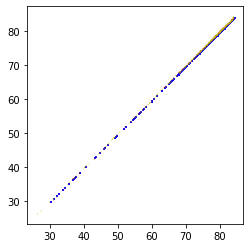

In [35]:

from sklearn.metrics import mean_absolute_error
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_absolute_error
import datetime

obj = 0
#print(xtrain)

import matplotlib.pyplot as plt
from scipy.stats import kde



predictions=[]
predictions_t=[]

with PdfPages('report_NN_sampleDataset_009'+str(datetime.datetime.today())+'.pdf') as pdf:
    txt1="NN standard"
    txt2="Date: "+str(datetime.datetime.today())
    txt3="dataset: sampleDatatset_009"
    txt4="notes:"
    plt.text(0.15,0.7,txt1, transform=fig.transFigure, size=20)
    plt.text(0.15,0.55,txt2, transform=fig.transFigure, size=20)
    plt.text(0.15,0.35,txt3, transform=fig.transFigure, size=20)
    plt.text(0.15,0.15,txt4, transform=fig.transFigure, size=20)

    pdf.savefig()
    plt.close()
        
    while obj<ydim:
    
        predictions.append(models[obj].predict(xtest)*norms[obj])   
        predictions_t.append(models[obj].predict(xtrain)*norms[obj])
    
        norm_test= "normalized test MAE: "+ str(mean_absolute_error(ytest[:,obj], predictions[obj])/np.average(ytest[:,obj])*100)+"%"
        norm_train= "normalized train MAE: "+ str(mean_absolute_error(ytrain[:,obj], predictions_t[obj])/np.average(ytrain[:,obj])*100)+ "%"

         
        
        fig = plt.figure()
        ax2 = fig.add_subplot(111)


    
        heatplots=False
        if heatplots:
            nbins=300
            k = kde.gaussian_kde( [  ytest[:,obj], predictions[obj]  ])
            xi, yi = np.mgrid[ytest[:,obj].min():ytest[:,obj].max():nbins*1j, predictions[obj].min():predictions[obj].max():nbins*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))

            ax2.pcolormesh(xi, yi, zi.reshape(xi.shape))
        #plt.show()
    
        
        plt.text(0.05,0.95,norm_test, transform=fig.transFigure, size=10)
        plt.text(0.05,0.9,norm_train, transform=fig.transFigure, size=10)
        ax2.scatter(ytest[:,obj], ytest[:,obj],
             
                 label='y=x',
                s=100, c='y', marker="s",
                 )
        ax2.scatter(ytrain[:,obj], predictions_t[obj],
                 s=1, c='b', marker="o",
                 label='training Prediction')
    
        ax2.scatter(ytest[:,obj], predictions[obj],
                 s=1, c='r', marker="o",
                 label='Prediction')
#     ax2.scatter(ytest[:,obj], ytrain[:,obj], 
#              s=1, c='g', marker="o",
#              label='Prediction')

    
    

    
    
        ax2.set_aspect(1)
    
    
        print('normalized MAE: ', 100* mean_absolute_error(ytest[:, obj], predictions[obj])/np.average(ytest[:,obj]) , '%' )    
        print('normalized MAE (training set): ', 100* mean_absolute_error(ytrain[:, obj], predictions_t[obj])/np.average(ytrain[:,obj]) , '%' )    
        if obj==0:
            ax2.set_xlabel('Transmission')
            ax2.set_ylabel('Transmission')
            #ax2.set_title("test")
            ax2.set_aspect(1)
        
        if obj==1:
            ax2.set_xlabel('EMIT_S')
            ax2.set_ylabel('EMIT_S')
            ax2.set_aspect(1)
        
        if obj==2:
            ax2.set_xlabel('EMIT_X')
            ax2.set_ylabel('EMIT_X')
            ax2.set_aspect(1)
    
        if obj==3:
            ax2.set_xlabel('EMIT_Y')
            ax2.set_ylabel('EMIT_Y')
            ax2.set_aspect(1)
        
    
        if obj==4:
            ax2.set_xlabel('X emit (mm*mrad)')
            ax2.set_ylabel('X emit (mm*mrad)')
#         ax2.set_xlim(.01, .07)
#         ax2.set_ylim(.01, .07)
                
        if obj==5:
            ax2.set_xlabel('Y emit (mm*mrad)')
            ax2.set_ylabel('Y emit (mm*mrad)')
            ax2.set_xlim(.01, .07)
            ax2.set_ylim(.01, .07)
            ax2.set_aspect(1)
        



        plt.legend(loc='upper left');
        pdf.savefig()
        plt.close()
        obj = obj +1
        
  



        i=0
    while i<ydim:
        plt.hist(ytrain[:,i], bins=20)
        if i==0:
            #plt.title("avg: "+str(np.average(ytrain[:,i])))

            plt.xlabel('Transmission')
            plt.ylabel('num_datapoints')
            plt.text(0.05,0.9,"average: "+ str(np.average(ytrain[:,i])), transform=fig.transFigure, size=10)

            print("avg: ",np.average(ytrain[:,i]))

        if i==1:
            plt.xlabel('emit_s')
            plt.ylabel('num_datapoints')
            plt.text(0.05,0.9,"average: "+ str(np.average(ytrain[:,i])), transform=fig.transFigure, size=10)

            print("avg: ",np.average(ytrain[:,i]))

        if i==2:
            plt.xlabel('emit_x')
            plt.ylabel('num_datapoints')
            plt.text(0.05,0.9,"average: "+ str(np.average(ytrain[:,i])), transform=fig.transFigure, size=10)

            print("avg: ",np.average(ytrain[:,i]))


        if i==3:
            plt.xlabel('emit_y')
            plt.ylabel('num_datapoints')
            plt.text(0.05,0.9,"average: "+ str(np.average(ytrain[:,i])), transform=fig.transFigure, size=10)
            print("avg: ",np.average(ytrain[:,i]))



        if i==4:
            plt.xlabel('X emit (mm*mrad)')
            plt.ylabel('num_datapoints')
            print("avg: ",np.average(ytrain[:,i]))
            plt.text(0.05,0.9,"average: "+ str(np.average(ytrain[:,i])), transform=fig.transFigure, size=10)

        if i==5:
            plt.xlabel('X emit (mm*mrad)')
            plt.ylabel('num_datapoints')
            print("avg: ",np.average(ytrain[:,i]))
            plt.text(0.05,0.9,"average: "+ str(np.average(ytrain[:,i])), transform=fig.transFigure, size=10)

    #print(" value:  ",  pow(np.average(predictions[obj]-ytest[:,obj]), 2)      /       pow(np.average(ytest[:,obj]), 2))
        pdf.savefig()
        plt.close()
        i=i+1




























normalized MAE:  0.14490453612714532 %
normalized MAE (training set):  0.13777752728084833 %
normalized MAE:  0.47202058925738194 %
normalized MAE (training set):  0.4356312480761443 %
normalized MAE:  0.39347619368800374 %
normalized MAE (training set):  0.3563429696502556 %
normalized MAE:  0.41742522777311714 %
normalized MAE (training set):  0.38703881990987765 %
avg:  71.824
avg:  0.06568054285714285
avg:  0.04629144285714286
avg:  0.05145511428571429


<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Generate Database</strong>
    </div>

</html>

IndexError: index 4 is out of bounds for axis 1 with size 4

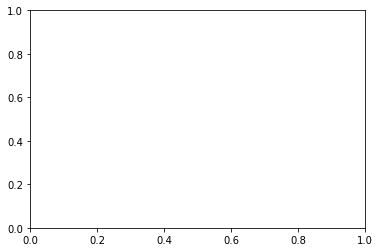

In [81]:
obj = 4
#print(xtrain)

import matplotlib.pyplot as plt
from scipy.stats import kde




while obj<5:
    
 
    ax2 = fig.add_subplot(111)
    #ytrain.append(ytrain[1,1])
    #ytest = np.delete(ytest, 0, axis=0)
    #predictions = np.delete(predictions, 2)
#     #np.delete(ytest[:,obj], 1)
#     print(len(predictions))
#     print(len(ytest[:,obj]))
#     print(len(ytrain[:,obj]))


    
    heatplots=True
    if heatplots:
        nbins=300
        k = kde.gaussian_kde( [  ytest[:,obj], predictions  ])
        xi, yi = np.mgrid[ytest[:,obj].min():ytest[:,obj].max():nbins*1j, predictions.min():predictions.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        ax2.pcolormesh(xi, yi, zi.reshape(xi.shape))
        #plt.show()
    
        
    
    ax2.scatter(ytest[:,obj], ytest[:,obj],
             
             label='y=x',
            s=10, c='y', marker="s",
             )
    ax2.scatter(ytest[:,obj], predictions,
             s=.01, c='r', marker="o",
             label='Prediction')
#     ax2.scatter(ytest[:,obj], ytrain[:,obj], 
#              s=1, c='g', marker="o",
#              label='Prediction')
    
    
    
    

    
    
    ax2.set_aspect(1)
    
    
    
    
    
    if obj==0:
        ax2.set_xlabel('transmission(%)')
        ax2.set_ylabel('transmission(%)')
        ax2.set_aspect(1)
        
    if obj==1:
        ax2.set_xlabel('Energy(MeV)')
        ax2.set_ylabel('Energy(MeV)')
        ax2.set_aspect(1)
        
    if obj==2:
        ax2.set_xlabel('length(mm)')
        ax2.set_ylabel('length(mm)')
        ax2.set_aspect(1)
    
    if obj==3:
        ax2.set_xlabel('Longitudinal emit (mm*mrad)')
        ax2.set_ylabel('Longitudinal emit (mm*mrad)')
        ax2.set_aspect(1)
        
    
    if obj==4:
        ax2.set_xlabel('X emit (mm*mrad)')
        ax2.set_ylabel('X emit (mm*mrad)')
        ax2.set_xlim(.01, .07)
        ax2.set_ylim(.01, .07)
                
    if obj==5:
        ax2.set_xlabel('Y emit (mm*mrad)')
        ax2.set_ylabel('Y emit (mm*mrad)')
        ax2.set_xlim(.01, .07)
        ax2.set_ylim(.01, .07)
        ax2.set_aspect(1)
        

    #ax2.set_xlim(0.055, .1)
    #ax2.set_ylim(0, .1)
    #ax2.set_xlim(0, .1)
    plt.legend(loc='upper left');
    
    plt.show()
    #print(" value:  ",  pow(np.average(predictions[obj]-ytest[:,obj]), 2)      /       pow(np.average(ytrain[:,obj]), 2))
    print('L2 error norm in validation points: ', eval_l2_error(ytrue=ytest[:, i], ypred=ypred_test))
    obj = obj +1
    


In [ ]:

import pandas as pd 

from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mclr


voltages=np.array([15,15.5,16,15,15.5,16,15.5,16,15.5,16,16,16,16,17,17.5,18,17.5,18,18])
angles=np.array([20,20,20,20.5,20.5,20.5,21,21,21.5,21.5,22,22.5,23,25,25,25,26,26,27])
emits=np.array([0.000000135,0.000000136197,0.000000138,0.000000133,0.000000135,0.000000136437,0.000000133,0.000000135,0.000000132,0.000000133,0.000000132,0.000000131,0.00000013,0.000000127,0.000000128,0.000000129,0.000000125,0.000000126,0.00000012386])

angle,voltages = np.meshgrid(angles, voltages, indexing='ij')
  
#voltages, angles = np.meshgrid(voltages, angles) 
  
# surface plot for a + b 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.pcolormesh(angles, voltages, emits, edgecolors='w',cmap="plasma")
  
plt.show() 








In [ ]:
# Rho histogram
#fig, ax = plt.subplots()
#
#plt.sca(ax[0, 2])


voltages=np.array([15,15.5,16,15,15.5,16,15.5,16,15.5,16,16,16,16,17,17.5,18,17.5,18,18])
angles=np.array([20,20,20,20.5,20.5,20.5,21,21,21.5,21.5,22,22.5,23,25,25,25,26,26,27])
emits=np.array([0.000000135,0.000000136197,0.000000138,0.000000133,0.000000135,0.000000136437,0.000000133,0.000000135,0.000000132,0.000000133,0.000000132,0.000000131,0.00000013,0.000000127,0.000000128,0.000000129,0.000000125,0.000000126,0.00000012386])
#emits= normalize(emits)

plt.hist2d(angles, voltages,  bins=[10, 10],range=[[19, 28], [13, 20]],
           weights=emits, cmap=plt.cm.rainbow)
plt.clim(.00000012, .00000014)
plt.colorbar()

plt.xlabel("angles")
plt.ylabel("voltages")
plt.title("Charge Density (C/m^3)")
plt.gca().set_aspect(1)

<html>
    <div class="alert alert-info" role="alert" style="margin-top: 10px; font-size: 30px;">
        <strong>Plot Main and Total Sensitivities</strong>
    </div>
</html>

In [ ]:
from scipy.optimize import minimize_scalar


import itertools as it
import subprocess
from scipy import optimize as opt
import numpy as npr
from time import time, ctime
from datetime import date
from datetime import datetime as dt
import wave
import random
from bayes_opt import BayesianOptimization
import sys
import os

from db import mldb
import numpy as np


#from mllib.model import *
#from mllib.data import OpalDataSource
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def opt_fun (lmax, n, a, learn_rate):

    # list of hyperparams: number of layers(lmax), number of nodes per layer(n[l]), activation function(a[l], =0,1,2) 
    # learning rate
    
    model = Sequential()
    model.add(Dense(14, input_dim=14, activation='sigmoid'))
    
    l=0
    while l<lmax:
        if a[l]==0:
            model.add(Dense(n[l], activation='relu'))
    
        if a[l]==1:
            model.add(Dense(n[l], activation='tanh'))
        if a[l]==2:
            model.add(Dense(n[l], activation='sigmoid'))
        l=l+1
    
    
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Dense(6))
    #model.summary()




# Compile the model
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        #use loss squared function
        optimizer=keras.optimizers.Adam(learning_rate=learn_rate),
        #switch to adam
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )
    
    
    
    obj=5
    models=[]
    norms=[]
    epochs=1000
    batch_size=1024

    print(len(ytrain[:,obj]))
    print(len(ytrain[obj,:]))
    while obj<6:
    
        normfactor=np.max(ytrain[:,obj])*1.1
        print(normfactor)
        #normfactor=normalize(ytrain[:,obj])
        #trainer=normalize(ytrain[:,obj])
        norms.append(normfactor)
        model.fit(xtrain, ytrain[:,obj]/normfactor, batch_size=batch_size, epochs=epochs, validation_split=0.0)
        # Test the model
        #model.evaluate(xtest, ytest[:,obj])
        models.append(model)
        obj=obj+1
        #shuffle_weights(model, weights=None)
    
    obj=5
    
    
    
    utility=99999999999999999999999
    print("MAE: ", np.average(abs(models[0].predict(xtest)*norms[0]-ytest[:,5])))
    utility= -1*np.average(abs(models[0].predict(xtest)*norms[0]-ytest[:,5]))
    
    
    
    print("utility: ", utility)
    return utility
    

In [ ]:
def opt_fun2 (nodes, learn_rate):
    print("nodes: ", round(nodes), "      learn_rate:", learn_rate)
    global iteration 
    iteration = iteration+1
    print("iteration:  ", iteration)
    
    return opt_fun(5,[15,20,20,20, round(nodes)], [1,1,1,1,1], learn_rate)
  

In [ ]:
#print(opt_fun(x0))
#res = minimize(opt_fun, x0, method='nelder-mead',
#               options={'xatol': 1e-5, 'disp': True})
#res = minimize_scalar(opt_fun, bounds=    )

field_scale = 1 # Adjustments to field strength weight for optimization
# Params for optimizer
n_iter = 400
init_points = 20


printout= "words"


def main():
    global printout
    #numProc = mp.cpu_count() # Number of Processes to spawn
    #x0 = np.asarray([000.0, 00.0, 000.0])
    #dimension=14
    start = time()

    print('Optimizing using BO, PP')


    
    

    
    
    #lmax=5
    
    # 18 parameter bounds Format: 'name': (min, max), 
    bnds = {
        'nodes': (1, 80),
        'learn_rate': (0, .01)
        } 

    
    
    # Optimization process
    optimizer = BayesianOptimization(
        f=opt_fun2,
        pbounds=bnds,
        verbose=0,
        random_state=1,
    )

    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )
    results = optimizer.max


    print('-------------------------------------------------')
    print( 'OPTIMIZATION ENDED' )
    print( "utility:", -1*results['target'])
    print ("params: ", results['params'])
    
    printout= 'printout: '
    printout.append("utility: ", -1*results['target'], "           params:", results['params'])

    end = time()
    print("Elapsed time: ", end - start, " seconds")
    


    print("optimization completed:", dt.now().strftime('%y.%m.%d-%H:%M:%S')        )
  
  
main()







In [ ]:
print(printout)

In [ ]:
import matplotlib.pyplot as plt
plt.legend(loc='upper left');
plt.figure(figsize=(12, 9), dpi=150)
plt = plot_sensitivity(allsens_m, dnames=xnames, outnames=ynames, sens_type='Main')

plt.savefig('main_sensitivty_order_' + str(order) + '.png', bbox_inches='tight')
plt.close()

In [ ]:
plt.figure(figsize=(12, 9), dpi=150)
plt = plot_sensitivity(allsens_t, dnames=xnames, outnames=ynames, sens_type='Total')

plt.savefig('total_sensitivty_order_' + str(order) + '.png', bbox_inches='tight')
plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print(len(xvals))
print(len(yvals))
print(len(ypred_test))
print(len(xtest))

obj=0


while obj<6:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.scatter(xvals[:,obj], yvals[:,obj],
             
            label='Data',
           s=10, c='b', marker="s",
            )
    ax1.scatter(xtest[:,obj], ypred_test,
             s=10, c='r', marker="o",
             label='Prediction')

    #ax1.set_ylim(0, 1.)
    plt.legend(loc='upper left');

#plt.plot(xvals[:,1], yvals[:,1], label='')
    plt.show()
    obj = obj +1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

obj = 0
#print(xtrain)


while obj<6:
    predictions=[]
    predictions=models[obj].predict(xtest)*norms[obj]
    print(len(predictions))
    print(len(ytest))
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    

    ax2.scatter(ytest[:,obj], ytest[:,obj],
             
             label='y=x',
            s=1, c='b', marker="s",
             )
    ax2.scatter(ytest[:,obj], predictions,
             s=1, c='r', marker="o",
             label='Prediction')
    ax2.set_aspect(1)
    
    
    
    
    if obj==0:
        ax2.set_xlabel('transmission(%)')
        ax2.set_ylabel('transmission(%)')
    
    if obj==1:
        ax2.set_xlabel('Energy(MeV)')
        ax2.set_ylabel('Energy(MeV)')
        
    if obj==2:
        ax2.set_xlabel('length(mm)')
        ax2.set_ylabel('length(mm)')
        
    
    if obj==3:
        ax2.set_xlabel('Longitudinal emit (mm*mrad)')
        ax2.set_ylabel('Longitudinal emit (mm*mrad)')
        
        
    
    if obj==4:
        ax2.set_xlabel('X emit (mm*mrad)')
        ax2.set_ylabel('X emit (mm*mrad)')
                
    if obj==5:
        ax2.set_xlabel('Y emit (mm*mrad)')
        ax2.set_ylabel('Y emit (mm*mrad)')
        

    #ax2.set_xlim(0.055, .1)
    #ax2.set_ylim(0, .1)
    #ax2.set_xlim(0, .1)
    plt.legend(loc='upper left');
    

#plt.plot(xvals[:,1], yvals[:,1], label='')
    plt.show()
    obj = obj +1


In [ ]:
#print(xtest)




i=0

print("output:  ")
#print(output)
#print(len(output))
print("   ")
print("xtest:   ")
print(xtest)
print(len(xtest[i,:]))
print(len(xtest[:,i]))



xinput = [[10.01277,
102.13058,
11.38499,
150.15528,
149.87416,
32.79421,
47.35732,
91.13554,
1.0339,
1.18602,
1.55939,
-85.4561,
-65.20657,
-56.44278],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]


outputs =[]


# while i<14:
    
#      print(xtest[0,i]         )
#      #outputs.append(output[i])
#      #print(output[i])
     
#      i=i+1

p=0
while p<6:
    outputs.append(surrogates[p].predict(xinput))
    print(surrogates[p].predict(xinput))
    p=p+1    
    print(len(outputs))

print("")    
print("outputs: ")    
print("")
p=0
while p<6:
    print(outputs[p][0])
    p=p+1        
    


    
    
    
weights =[1,1,1,1,1,1,1]
# #utility = 




In [ ]:
i=0
while i<6:
    plt.hist(ytrain[:,i], bins=20)
    
    plt.show()
    i=i+1



In [ ]:
from scipy.optimize import minimize_scalar


import itertools as it
import subprocess
from scipy import optimize as opt
import numpy as npr
from time import time, ctime
from datetime import date
from datetime import datetime as dt
import wave
import random
import multiprocessing as mp
from bayes_opt import BayesianOptimization
import sys
import os




def opt_fun (dvar1,dvar2,dvar3,dvar4,dvar5,dvar6,dvar7,dvar8,dvar9,dvar10,dvar11,dvar12,dvar13,dvar14):
    
    utility=0
#     utility=0
#     dvar1=x[0]
#     dvar2=x[1]
#     dvar3=x[2]
#     dvar4=x[3]
#     dvar5=x[4]
#     dvar6=x[5]
#     dvar7=x[6]
#     dvar8=x[7]
#     dvar9=x[8]
#     dvar10=x[9]
#     dvar11=x[10]
#     dvar12=x[11]
#     dvar13=x[12]
#     dvar14=x[13]
#     obj=x[14]
    
    
    
    
    
    
    
    xinput = [[dvar1,
    dvar2,
    dvar3,
    dvar4,
    dvar5,
    dvar6,
    dvar7, 
    dvar8, 
    dvar9, 
    dvar10,
    dvar11,
    dvar12,
    dvar13, 
    dvar14],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]
    outputs=[]
    outputs.clear()
    obj=6
    p=0
    while p<obj:
        outputs.append(surrogates[p].predict(xinput))
        p=p+1    
    
    
    optimum = [100, 70, 130, 0, 0, 0]
    weights= [ 0.4/50, 0.05/.075, 0.05/140, 0.4/.006, 0.05/.0035, 0.05/.0035]
    obj=6
    
    
    i=0
    while i<obj:
        utility += -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])
        i=i+1
        
    return utility
    
    

x0 = [10.01277,
102.13058,
11.38499,
150.15528,
149.87416,
32.79421,
47.35732,
91.13554,
1.0339,
1.18602,
1.55939,
-85.4561,
-65.20657,
-56.44278,
     6]


#print(opt_fun(x0))
#res = minimize(opt_fun, x0, method='nelder-mead',
#               options={'xatol': 1e-5, 'disp': True})
#res = minimize_scalar(opt_fun, bounds=    )

field_scale = 1 # Adjustments to field strength weight for optimization
# Params for optimizer
n_iter = 1000
init_points = 10




def main():
    numProc = mp.cpu_count() # Number of Processes to spawn
    x0 = np.asarray([000.0, 00.0, 000.0])
    dimension=14
    start = time()

    print('Optimizing using BO, PP')

    #dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min = 30,30,30,30,30,30,30,30,30,30,30,30,30,30
    dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min = 10.01277,102.13058,8.38499,120.15528,129.87416,32.79421,47.35732,91.13554,1.0339,1.18602,1.55939,-85.4561,-5.20657,-56.44278
    #dvar1max, dvar2max, dvar3max, dvar4max, dvar5max, dvar6max, dvar7max, dvar8max, dvar9max, dvar10max, dvar11max, dvar12max,  dvar13max, dvar14max = 40,40,40,40,40,40,40,40,40,40,40,40,40,40
    dvar1max, dvar2max, dvar3max, dvar4max, dvar5max, dvar6max, dvar7max, dvar8max, dvar9max, dvar10max, dvar11max, dvar12max,  dvar13max, dvar14max = 20.01277,112.13058,11.38499,150.15528,150.87416,35.79421,50.35732,96.13554,1.839,2.18602,2.55939,-75.4561,-3.20657,-46.44278

    print(opt_fun(dvar1min, dvar2min, dvar3min, dvar4min, dvar5min, dvar6min, dvar7min, dvar8min, dvar9min, dvar10min, dvar11min, dvar12min,  dvar13min, dvar14min))
    
#     bnds = {
#         (dvar1min, dvar1max),
#         (dvar2min, dvar2max),
#         (dvar3min, dvar3max),
        
#         (dvar4min, dvar4max),
#         (dvar5min, dvar5max),
#         (dvar6min, dvar6max),
#         (dvar7min, dvar7max),
#         (dvar8min, dvar8max),
#         (dvar9min, dvar9max),
#         (dvar10min, dvar10max),
#         (dvar11min, dvar11max),
#         (dvar12min, dvar12max),
        
#         (dvar13min, dvar13max),
#         (dvar14min, dvar14max)
        
#         }
    
    
    
    
    # 18 parameter bounds Format: 'name': (min, max), 
    bnds = {
        'dvar1': (10, 11),
        'dvar2': (1, 200.0),
        'dvar3': (1, 200.0),
        'dvar4': (1, 200.0),
        'dvar5': (1, 200.0),
        'dvar6': (13.0, 33.0),
        'dvar7': (45, 65.0),
        'dvar8': (85, 105.0),
        'dvar9': (1.005, 1.05),
        'dvar10': (1.15, 1.350),
        'dvar11': (1.55, 1.750),
        'dvar12': (-89.9, -85.0),
        'dvar13': (-77.50, -62.50 ),
        'dvar14': (-57.5, -42.5)
        } 

    
    
    # Optimization process
    optimizer = BayesianOptimization(
        f=opt_fun,
        pbounds=bnds,
        verbose=0,
        random_state=1,
    )

    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )
    results = optimizer.max


    print('-------------------------------------------------')
    print( 'OPTIMIZATION ENDED' )
    print( "utility:", -1*results['target'])
    print ("params: ", results['params'])

    end = time()
    print("Elapsed time: ", end - start, " seconds")
    


    print("optimization completed:", dt.now().strftime('%y.%m.%d-%H:%M:%S')        )
  
  
main()







In [ ]:
def opt_fun_2 (dvar1,dvar2,dvar3,dvar4,dvar5,dvar6,dvar7,dvar8,dvar9,dvar10,dvar11,dvar12,dvar13,dvar14):
  
    utility=0
#     utility=0
#     dvar1=x[0]
#     dvar2=x[1]
#     dvar3=x[2]
#     dvar4=x[3]
#     dvar5=x[4]
#     dvar6=x[5]
#     dvar7=x[6]
#     dvar8=x[7]
#     dvar9=x[8]
#     dvar10=x[9]
#     dvar11=x[10]
#     dvar12=x[11]
#     dvar13=x[12]
#     dvar14=x[13]
#     obj=x[14]
    
    
    
    
    
    
    
    xinput = [[dvar1,
    dvar2,
    dvar3,
    dvar4,
    dvar5,
    dvar6,
    dvar7, 
    dvar8, 
    dvar9, 
    dvar10,
    dvar11,
    dvar12,
    dvar13, 
    dvar14],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0]
         ]
    outputs=[]
    outputs.clear()
    obj=6
    p=0
    while p<obj:
        outputs.append(surrogates[p].predict(xinput))
        p=p+1    
    
    
    optimum = [100, 70, 120, 0, 0, 0]
    weights= [ 0.4/90, 0.05/.075, 0.05/140, 0.4/.06, 0.05/.035, 0.05/.035]
    obj=6
    
    
    i=0
    while i<obj:
        utility += -((optimum[i]-outputs[i][0])*(optimum[i]-outputs[i][0])*weights[i])
        print(outputs[i][0])
        i=i+1
        
    
    return utility


#opt_fun_2(10.32654950508622,114.09776918706348,95.03503058186705,  4.9373454675155966, 166.65840782020405,  14.51445462045868, 60.39738085611873, 97.90828399113782,  1.0350016324169173,  1.2932711161614976,  1.6896462159652843,  -88.86681948986129, -76.97132158039432, -47.91867664340158)
#opt_fun_2(10.0,141.20474878480792, 131.412409553512,  4.572527379802288,  35.30223532987305,  33.0,  55.496663301669955,  85.0, 1.05, 1.15,  1.75,  -89.9,  -77.5,  -57.5,)
opt_fun_2( 10.0, 141.20474878480792, 131.412409553512, 4.572527379802288, 35.30223532987305, 33.0, 55.496663301669955, 85.0,  1.05, 1.15,  1.75,  -89.9,  -77.5,  -57.5)